In [1]:
!pip install pycaret 
! pip install optuna 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | / done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 82.2 MB/s

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 

In [3]:
from cycler import cycler


raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
]

raw_gray_light_palette = [
    (142, 142, 147),# Gray
    (174, 174, 178),# Gray (2)
    (199, 199, 204),# Gray (3)
    (209, 209, 214),# Gray (4)
    (229, 229, 234),# Gray (5)
    (242, 242, 247),# Gray (6)
]

raw_gray_dark_palette = [
    (142, 142, 147),# Gray
    (99, 99, 102),  # Gray (2)
    (72, 72, 74),   # Gray (3)
    (58, 58, 60),   # Gray (4)
    (44, 44, 46),   # Gray (5)
    (28, 28, 39),   # Gray (6)
]


light_palette = np.array(raw_light_palette)/255
dark_palette = np.array(raw_dark_palette)/255
gray_light_palette = np.array(raw_gray_light_palette)/255
gray_dark_palette = np.array(raw_gray_dark_palette)/255

mpl.rcParams['axes.prop_cycle'] = cycler('color',dark_palette)
mpl.rcParams['figure.facecolor']  = gray_dark_palette[-2]
mpl.rcParams['figure.edgecolor']  = gray_dark_palette[-2]
mpl.rcParams['axes.facecolor'] =  gray_dark_palette[-2]

white_color = gray_light_palette[-2]
mpl.rcParams['text.color'] = white_color
mpl.rcParams['axes.labelcolor'] = white_color
mpl.rcParams['axes.edgecolor'] = white_color
mpl.rcParams['xtick.color'] = white_color
mpl.rcParams['ytick.color'] = white_color

mpl.rcParams['figure.dpi'] = 200

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [4]:
def calculate_apfd(faults_detected_order):
    num_faults = len(faults_detected_order)
    total_tests = sum(range(1, num_faults + 1))
    
    if num_faults == 0:
        return 0.0

    detected_positions = [i + 1 for i in faults_detected_order]
    apfd = 1 - (sum(detected_positions) / total_tests) + (num_faults / (2 * total_tests))
    
    return apfd
    
def calculate_apfd_from_probabilities(predicted_probabilities):
    # Assuming predicted_probabilities is a list of lists containing probabilities for each class
    num_classes = len(predicted_probabilities[0])
    num_tests = len(predicted_probabilities)

    # Sort the probabilities in descending order for each test
    sorted_probabilities = [sorted(enumerate(prob), key=lambda x: x[1], reverse=True) for prob in predicted_probabilities]

    # Create a list to store the order in which faults are detected
    faults_detected_order = []

    for i in range(num_tests):
        # Add the index of the detected fault (class) to the order list
        detected_fault_index = [index for index, _ in sorted_probabilities[i]]
        faults_detected_order.append(detected_fault_index.index(1))  # Assuming class 1 is the positive class

    # Calculate and return APFD
    apfd_value = calculate_apfd(faults_detected_order)
    return apfd_value

# Example usage:
# Replace predicted_probabilities with the actual output from predict_proba()
predicted_probabilities = [[0.9, 0.1], [0.3, 0.7], [0.8, 0.2]]
apfd_value = calculate_apfd_from_probabilities(predicted_probabilities)

print(f"APFD: {apfd_value}")



APFD: 0.41666666666666663


## EDA

In [5]:
data=pd.read_csv("/kaggle/input/tcp-data/dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30425 entries, 0 to 30424
Columns: 156 entries, Build to DET_COV_IMP_Faults
dtypes: float64(150), int64(6)
memory usage: 36.2 MB


In [6]:
data

,Build,Test,Verdict,Duration,TES_COM_CountDeclFunction,TES_COM_CountLine,TES_COM_CountLineBlank,TES_COM_CountLineCode,TES_COM_CountLineCodeDecl,TES_COM_CountLineCodeExe,...,COD_COV_PRO_IMP_AllCommitersExperience,COD_COV_CHN_C_LinesAdded,COD_COV_CHN_C_LinesDeleted,COD_COV_CHN_C_AddedChangeScattering,COD_COV_CHN_C_DeletedChangeScattering,COD_COV_CHN_C_DMMSize,COD_COV_CHN_C_DMMComplexity,COD_COV_CHN_C_DMMInterfacing,DET_COV_C_Faults,DET_COV_IMP_Faults
0,115071710,24123,0,82,13.0,203.0,42.0,105.0,34.0,63.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,115071710,24129,0,375,10.0,187.0,43.0,103.0,33.0,68.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,115071710,24130,0,783,21.0,496.0,122.0,307.0,118.0,250.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,115071710,24131,0,1583,24.0,623.0,139.0,395.0,72.0,332.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,115071710,24132,0,1888,19.0,411.0,86.0,261.0,71.0,189.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30420,128866605,19499,0,124,5.0,184.0,51.0,116.0,49.0,85.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
30421,128866605,19662,0,3,5.0,276.0,30.0,186.0,41.0,161.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
30422,128866605,19678,0,296,36.0,532.0,159.0,350.0,105.0,240.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
30423,128866605,19701,0,1979,25.0,830.0,223.0,534.0,187.0,433.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [7]:
data.isna().sum().sum()

0

there is no null data 

In [8]:
data['Verdict'].value_counts()
# 0 is successful
# 1 failure exception
# 2 failure assert

0    29215
1     1172
2       38
Name: Verdict, dtype: int64

In [9]:
data['Verdict']=data['Verdict'].replace({ 2:1 })
data['Verdict']=data['Verdict'].replace({ 0:1,1:0 })
data['Verdict'].value_counts()

1    29215
0     1210
Name: Verdict, dtype: int64

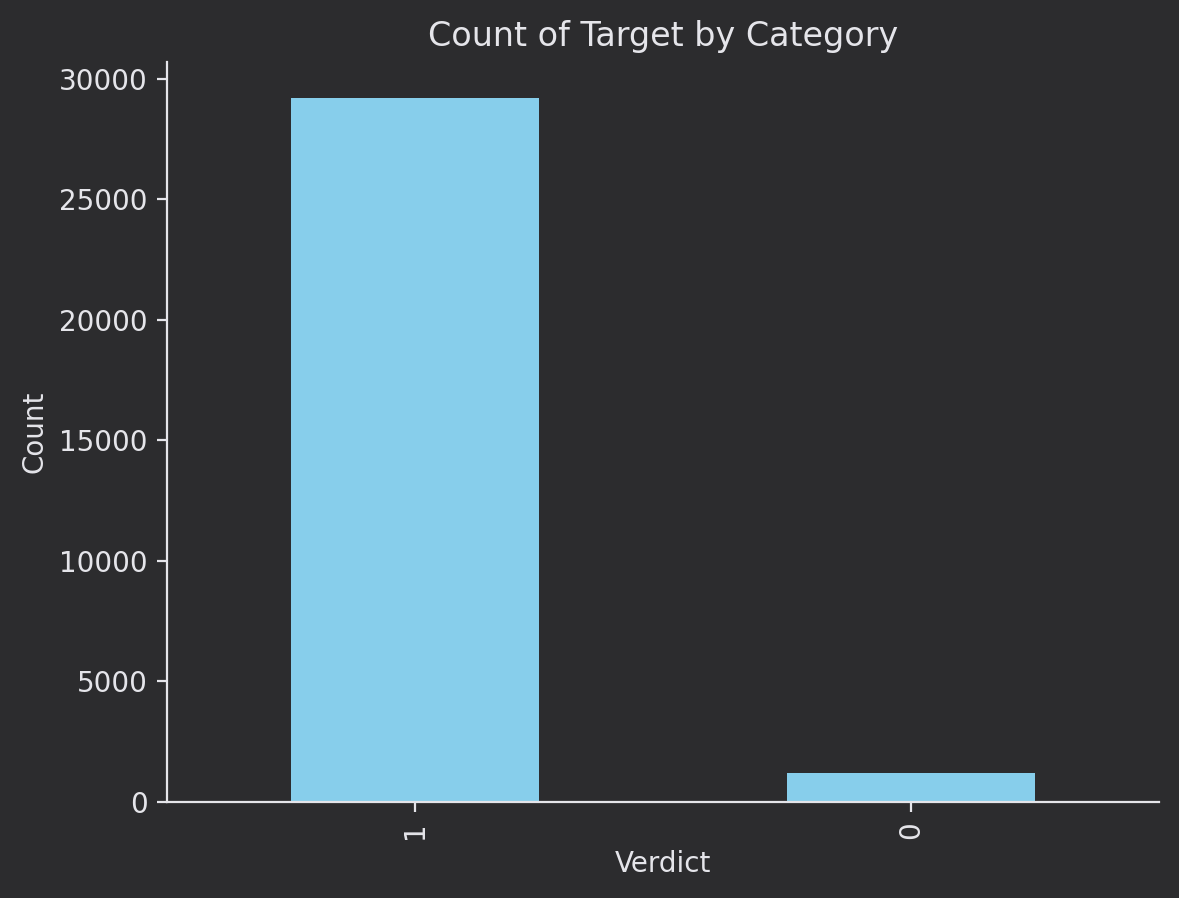

In [10]:
count_plot = data['Verdict'].value_counts().plot(kind='bar', color='skyblue')
count_plot.set_xlabel('Verdict')
count_plot.set_ylabel('Count')
count_plot.set_title('Count of Target by Category')
plt.show()

The number of fallout cases is significantly lower than the successful ones. Therefore, we need to address this imbalance. For instance, we might consider using SMOTE to handle the unbalanced data.

In [11]:
data.describe().T.style.bar(subset=['std'])

,count,mean,std,min,25%,50%,75%,max
Build,30425.000000,121969052.672243,4013784.009736,115071710.000000,119757362.000000,122449871.000000,125006475.000000,128866605.000000
Test,30425.000000,21842.092654,4892.924376,1769.000000,17427.000000,22611.000000,25394.000000,28921.000000
Verdict,30425.000000,0.960230,0.195421,0.000000,1.000000,1.000000,1.000000,1.000000
Duration,30425.000000,1257.278915,4232.930111,0.000000,42.000000,290.000000,1085.000000,158215.000000
TES_COM_CountDeclFunction,30425.000000,16.279037,25.454098,1.000000,4.000000,11.000000,16.279037,412.000000
TES_COM_CountLine,30425.000000,399.600087,587.053385,24.000000,107.000000,246.000000,399.600087,8735.000000
TES_COM_CountLineBlank,30425.000000,85.113886,130.418985,4.000000,20.000000,49.000000,85.113886,1923.000000
TES_COM_CountLineCode,30425.000000,259.988643,383.118697,9.000000,65.000000,155.000000,259.988643,5374.000000
TES_COM_CountLineCodeDecl,30425.000000,90.043164,113.330752,5.000000,29.000000,56.000000,90.043164,1310.000000
TES_COM_CountLineCodeExe,30425.000000,194.117460,312.252411,0.000000,37.000000,105.000000,194.117460,4419.000000


In [12]:
import umap.umap_ as umap

train_sub = data
target = train_sub['Verdict']
umap = umap.UMAP(random_state=0)
dr = umap.fit_transform(train_sub.iloc[:,:-1], target)

2024-02-17 15:23:59.189177: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 15:23:59.189292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 15:23:59.340031: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: 

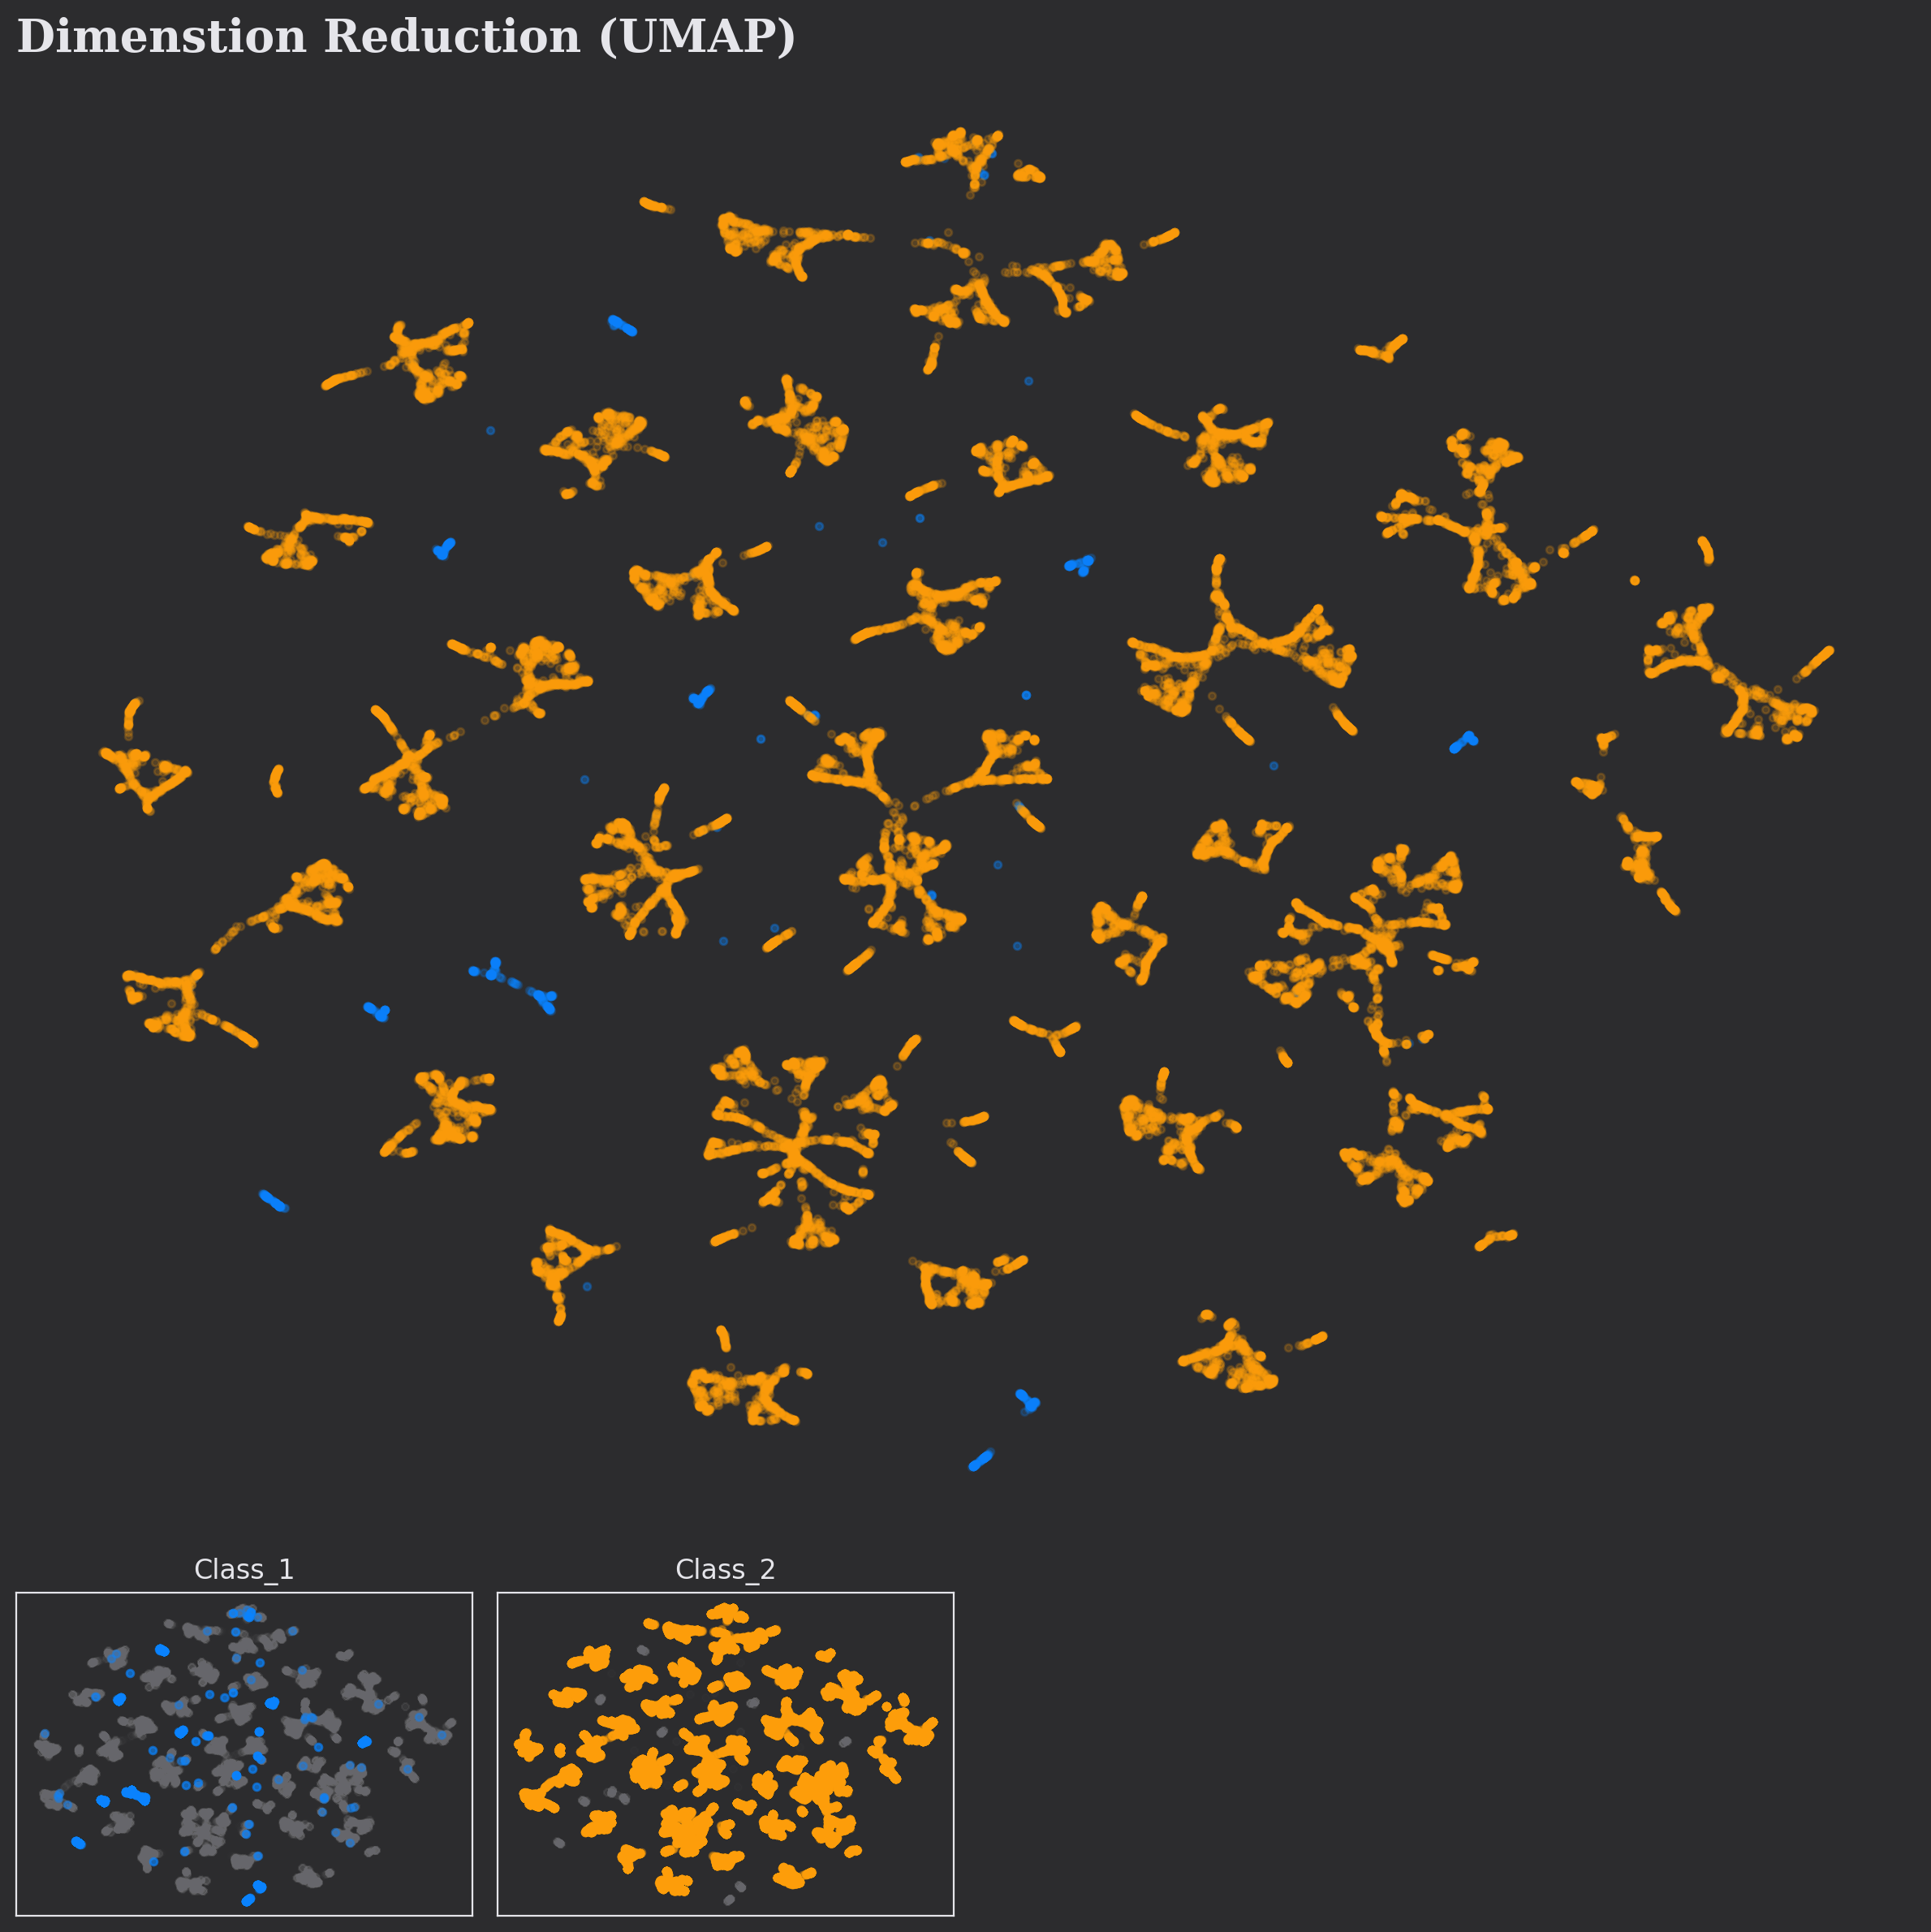

In [13]:
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(5, 4)
ax = fig.add_subplot(gs[:-1,:])

sub_axes = [None] * 2
for idx in range(2): 
    sub_axes[idx] = fig.add_subplot(gs[-1,idx])

for idx in range(2):
    ax.scatter(x=dr[:,0][target==idx], y=dr[:,1][target==idx],
              s=10, alpha=0.2
              )

    for j in range(2):
        sub_axes[j].scatter(x=dr[:,0][target==idx], y=dr[:,1][target==idx],
                              s=10, alpha = 0.4 if idx==j else 0.008, color = (dark_palette[j%9]) if idx==j else white_color,
                            zorder=(idx==j)
                           )
        
    
    sub_axes[idx].set_xticks([])
    sub_axes[idx].set_yticks([])
    sub_axes[idx].set_xlabel('')
    sub_axes[idx].set_ylabel('')
    sub_axes[idx].set_title(f'Class_{idx+1}')
    sub_axes[idx].spines['right'].set_visible(True)
    sub_axes[idx].spines['top'].set_visible(True)
    
ax.set_title('Dimenstion Reduction (UMAP)', fontweight='bold', fontfamily='serif', fontsize=20, loc='left')  
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig.tight_layout()
plt.show()

The umap has successfully divide the data into two class without many overlabs.

## modeling 

In [14]:
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def calculate_apfd(faults_detected_order):
    num_faults = len(faults_detected_order)
    total_tests = sum(range(1, num_faults + 1))
    
    if num_faults == 0:
        return 0.0

    detected_positions = [i + 1 for i in faults_detected_order]
    apfd = 1 - (sum(detected_positions) / total_tests) + (num_faults / (2 * total_tests))
    
    return apfd
    
def calculate_apfd_from_probabilities(predicted_probabilities):
    # Assuming predicted_probabilities is a list of lists containing probabilities for each class
    num_classes = len(predicted_probabilities[0])
    num_tests = len(predicted_probabilities)

    # Sort the probabilities in descending order for each test
    sorted_probabilities = [sorted(enumerate(prob), key=lambda x: x[1], reverse=True) for prob in predicted_probabilities]

    # Create a list to store the order in which faults are detected
    faults_detected_order = []

    for i in range(num_tests):
        # Add the index of the detected fault (class) to the order list
        detected_fault_index = [index for index, _ in sorted_probabilities[i]]
        faults_detected_order.append(detected_fault_index.index(1))  # Assuming class 1 is the positive class

    # Calculate and return APFD
    apfd_value = calculate_apfd(faults_detected_order)
    return apfd_value

def display_scores(y_true, y_pred):
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def evaluate_preds(y_true, y_pred, name):
    
    # Additional metrics for binary classification
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    metrics = {'model': name,
               'F1 Score': f1,
               'MCC': mcc,
                }
    display_scores(y_true, y_pred)
    return metrics


In [15]:
data.drop(['Build','Test','Duration'],axis=1,inplace=True)
data

,Verdict,TES_COM_CountDeclFunction,TES_COM_CountLine,TES_COM_CountLineBlank,TES_COM_CountLineCode,TES_COM_CountLineCodeDecl,TES_COM_CountLineCodeExe,TES_COM_CountLineComment,TES_COM_CountStmt,TES_COM_CountStmtDecl,...,COD_COV_PRO_IMP_AllCommitersExperience,COD_COV_CHN_C_LinesAdded,COD_COV_CHN_C_LinesDeleted,COD_COV_CHN_C_AddedChangeScattering,COD_COV_CHN_C_DeletedChangeScattering,COD_COV_CHN_C_DMMSize,COD_COV_CHN_C_DMMComplexity,COD_COV_CHN_C_DMMInterfacing,DET_COV_C_Faults,DET_COV_IMP_Faults
0,1,13.0,203.0,42.0,105.0,34.0,63.0,56.0,79.0,34.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,10.0,187.0,43.0,103.0,33.0,68.0,41.0,90.0,35.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1,21.0,496.0,122.0,307.0,118.0,250.0,67.0,253.0,107.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1,24.0,623.0,139.0,395.0,72.0,332.0,89.0,367.0,74.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1,19.0,411.0,86.0,261.0,71.0,189.0,64.0,230.0,80.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30420,1,5.0,184.0,51.0,116.0,49.0,85.0,17.0,101.0,44.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
30421,1,5.0,276.0,30.0,186.0,41.0,161.0,60.0,63.0,36.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
30422,1,36.0,532.0,159.0,350.0,105.0,240.0,23.0,285.0,83.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
30423,1,25.0,830.0,223.0,534.0,187.0,433.0,73.0,427.0,166.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


### Auto ML

In [16]:
from pycaret.classification import *
setup(data =data, 
      target = 'Verdict',
      numeric_imputation = 'median',
      fold=6
     )

,Description,Value
0,Session id,8881
1,Target,Verdict
2,Target type,Binary
3,Original data shape,"(30425, 153)"
4,Transformed data shape,"(30425, 153)"
5,Transformed train set shape,"(21297, 153)"
6,Transformed test set shape,"(9128, 153)"
7,Numeric features,152
8,Preprocess,True
9,Imputation type,simple


In [17]:
best_model = compare_models(sort = 'MCC', n_select = 3) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9973,0.9939,0.9997,0.9975,0.9986,0.9633,0.9638,2.3000
rf,Random Forest Classifier,0.9972,0.9865,0.9997,0.9974,0.9986,0.9625,0.9631,4.3100
et,Extra Trees Classifier,0.9971,0.9864,0.9992,0.9978,0.9985,0.9612,0.9615,2.4300
xgboost,Extreme Gradient Boosting,0.9970,0.9945,0.9996,0.9973,0.9985,0.9600,0.9606,3.1183
catboost,CatBoost Classifier,0.9970,0.9893,0.9996,0.9974,0.9985,0.9601,0.9606,15.8817
gbc,Gradient Boosting Classifier,0.9966,0.9835,0.9991,0.9974,0.9982,0.9541,0.9544,15.2267
ada,Ada Boost Classifier,0.9953,0.9863,0.9983,0.9968,0.9976,0.9371,0.9376,3.8950
dt,Decision Tree Classifier,0.9950,0.9680,0.9974,0.9975,0.9974,0.9348,0.9349,1.3583
lda,Linear Discriminant Analysis,0.9879,0.9694,0.9909,0.9965,0.9937,0.8510,0.8530,0.6733
knn,K Neighbors Classifier,0.9826,0.9647,0.9921,0.9898,0.9909,0.7652,0.7658,1.5467


Processing:   0%|          | 0/71 [00:00<?, ?it/s]

IUsing AutoML can be a helpful approach to quickly explore and identify suitable algorithms for our machine learning task.

As observed, tree-based algorithms have yielded optimal results; consequently, we intend to use them.



In [18]:
catboost = create_model('catboost')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9955,0.9933,0.9997,0.9956,0.9977,0.9380,0.9393
1,0.9966,0.9848,0.9997,0.9968,0.9982,0.9541,0.9548
2,0.9975,0.9953,0.9988,0.9985,0.9987,0.9669,0.9669
3,0.9980,0.9913,0.9994,0.9985,0.9990,0.9739,0.9739
4,0.9966,0.9872,0.9997,0.9968,0.9982,0.9541,0.9548
5,0.9980,0.9839,1.0000,0.9980,0.9990,0.9735,0.9739
Mean,0.9970,0.9893,0.9996,0.9974,0.9985,0.9601,0.9606
Std,0.0009,0.0043,0.0004,0.0011,0.0005,0.0128,0.0123


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

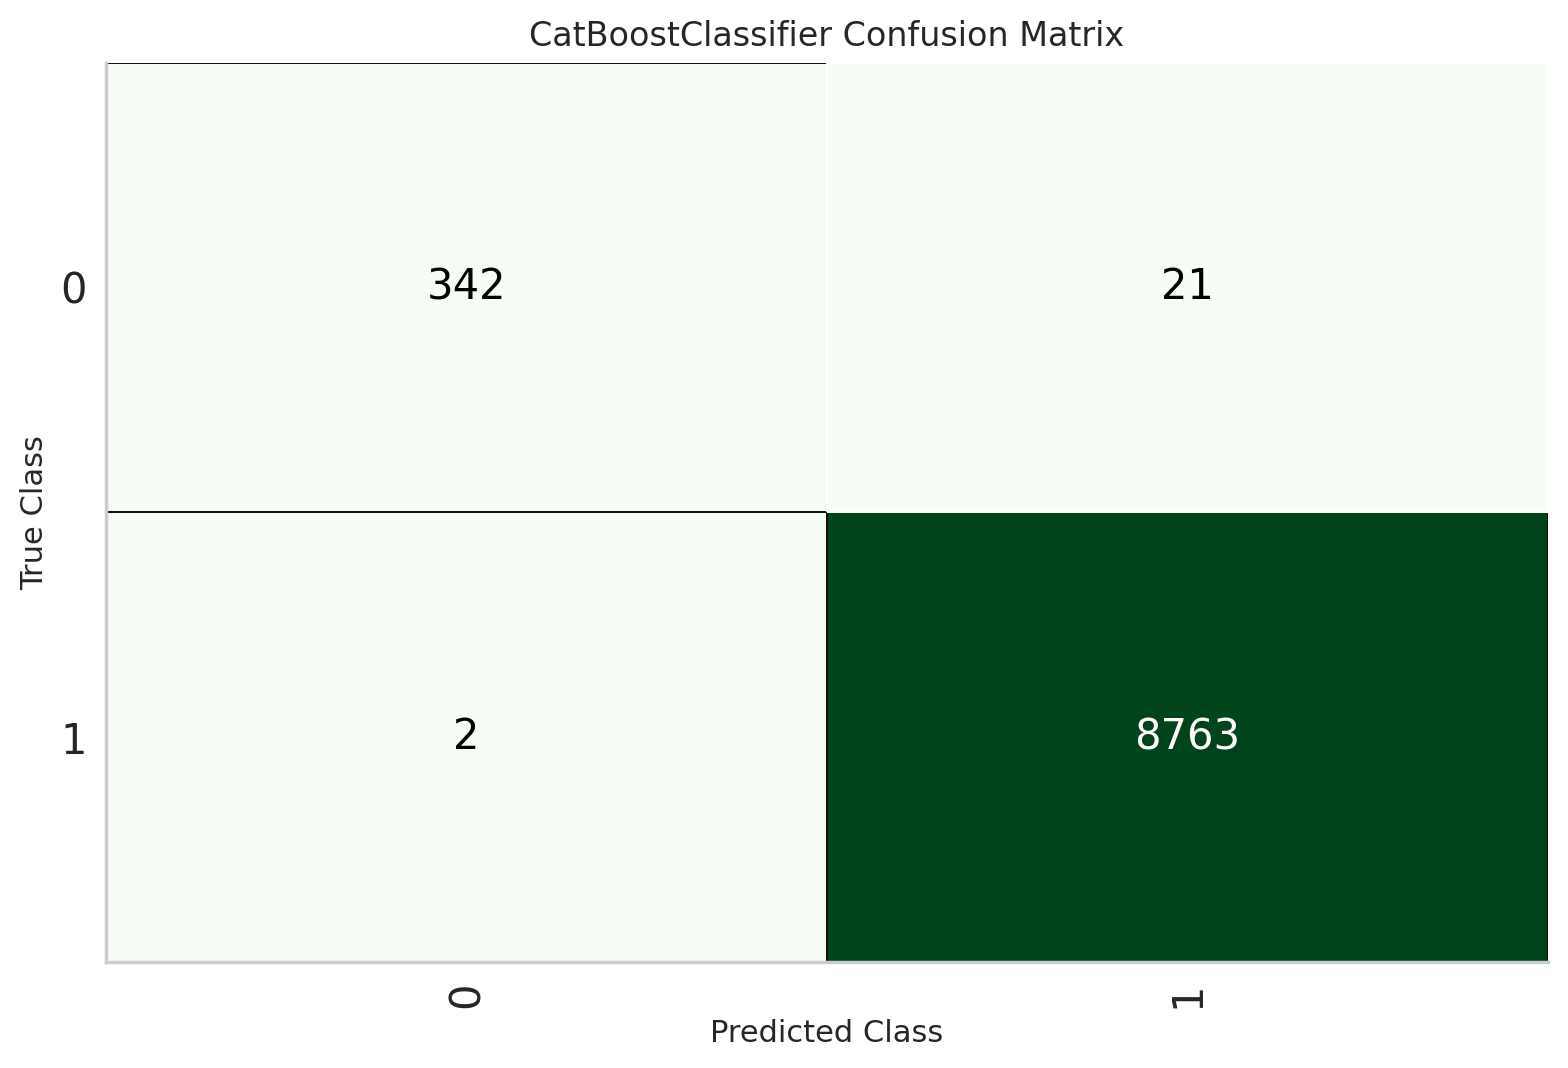

In [19]:
plot_model(catboost, plot = 'confusion_matrix')

In [20]:
#plot_model(catboost, plot = 'learning')

In [21]:
#plot_model(catboost, plot = 'vc')

In [22]:
#plot_model(catboost, plot = 'feature_all')

In [23]:
#interpret_model(lightgbm)

### ML

In [24]:
training = pd.DataFrame(index=None, columns=['model','F1 Score','MCC'])
testing=pd.DataFrame(index=None, columns=['model','F1 Score','MCC'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
data.drop('Verdict',axis=1), data['Verdict'], test_size=0.2, random_state=42)
feature_name=X_train.columns

X=data.drop('Verdict',axis=1)
y=data['Verdict']

In [25]:
from sklearn.ensemble import ExtraTreesClassifier #finding the best features

TOP_FEATURES = 75

forest = ExtraTreesClassifier(n_estimators=250, max_depth=10, random_state=1)
forest.fit(X_train,y_train)

importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_],
    axis=0
)
indices = np.argsort(importances)[::-1]
indices = indices[:TOP_FEATURES]

print('Top features:')
for f in range(TOP_FEATURES):
    print('{}.feature {} ({})' .format(f + 1, feature_name[indices[f]], importances[indices[f]]))

Top features:
1.feature MaxTestFileTransitionRate (0.08913263621417997)
2.feature TES_COM_CountDeclMethodDefault (0.08081205293144822)
3.feature MaxTestFileFailRate (0.0686064379834626)
4.feature REC_MaxTestFileFailRate (0.06534521571598599)
5.feature REC_MaxTestFileTransitionRate (0.055640051407214605)
6.feature REC_TotalAvgExeTime (0.05453440589112485)
7.feature REC_RecentAvgExeTime (0.0502405361522797)
8.feature REC_TotalTransitionRate (0.04830418036002902)
9.feature TES_COM_MaxEssential (0.04161656830212011)
10.feature REC_LastExeTime (0.03176802519888828)
11.feature REC_RecentMaxExeTime (0.026568488959456397)
12.feature TES_PRO_OwnersExperience (0.026002602072196748)
13.feature REC_RecentTransitionRate (0.023926770135844676)
14.feature REC_RecentExcRate (0.016806562585077994)
15.feature REC_TotalFailRate (0.016339799865622492)
16.feature REC_LastTransitionAge (0.015852084254774246)
17.feature REC_LastFailureAge (0.013149869723640477)
18.feature REC_LastVerdict (0.01247306076882853

In [26]:
X_train = X_train.iloc[:, indices]
X_test = X_test.iloc[:, indices]
X=X.iloc[:, indices]

In [27]:
X_train

,MaxTestFileTransitionRate,TES_COM_CountDeclMethodDefault,MaxTestFileFailRate,REC_MaxTestFileFailRate,REC_MaxTestFileTransitionRate,REC_TotalAvgExeTime,REC_RecentAvgExeTime,REC_TotalTransitionRate,TES_COM_MaxEssential,REC_LastExeTime,...,COD_COV_COM_IMP_CountDeclFunction,COD_COV_PRO_IMP_MinorContributorCount,COD_COV_COM_IMP_CountDeclClassMethod,COD_COV_PRO_IMP_OwnersExperience,TES_CHN_LinesAdded,COD_COV_PRO_IMP_AllCommitersExperience,COD_COV_COM_IMP_MaxCyclomaticModified,TES_CHN_DMMSize,COD_COV_COM_IMP_CountDeclMethod,COD_COV_COM_IMP_CountLineCodeExe
12217,-1.0,0.000000,-1.0,-1.0,-1.0,54.544688,23.833333,0.000000,1.000000,20.0,...,9.321708,0.390465,0.00659,43.104382,-1.0,24.352189,0.12824,-1.0,9.321708,9.276652
27541,-1.0,0.000000,-1.0,-1.0,-1.0,35.219368,20.166667,0.000000,1.000000,20.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000
24317,-1.0,0.000000,-1.0,-1.0,-1.0,110.227991,213.000000,0.000000,1.000000,82.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000
29340,-1.0,0.000000,-1.0,-1.0,-1.0,5134.058670,654.500000,0.000000,1.000000,702.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000
30154,-1.0,0.003892,-1.0,-1.0,-1.0,1517.603448,820.833333,0.000000,1.142596,656.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,-1.0,0.003892,-1.0,-1.0,-1.0,6.471698,5.333333,0.000000,1.142596,4.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000
5390,-1.0,0.000000,-1.0,-1.0,-1.0,44.598859,31.000000,0.000000,1.000000,37.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000
860,1.0,0.000000,0.5,0.5,0.5,341.618357,346.333333,0.009662,1.000000,284.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000
15795,-1.0,0.000000,-1.0,-1.0,-1.0,83.657364,71.833333,0.000000,1.000000,252.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000


Class distribution after SMOTE: Counter({1: 23370, 0: 23370})


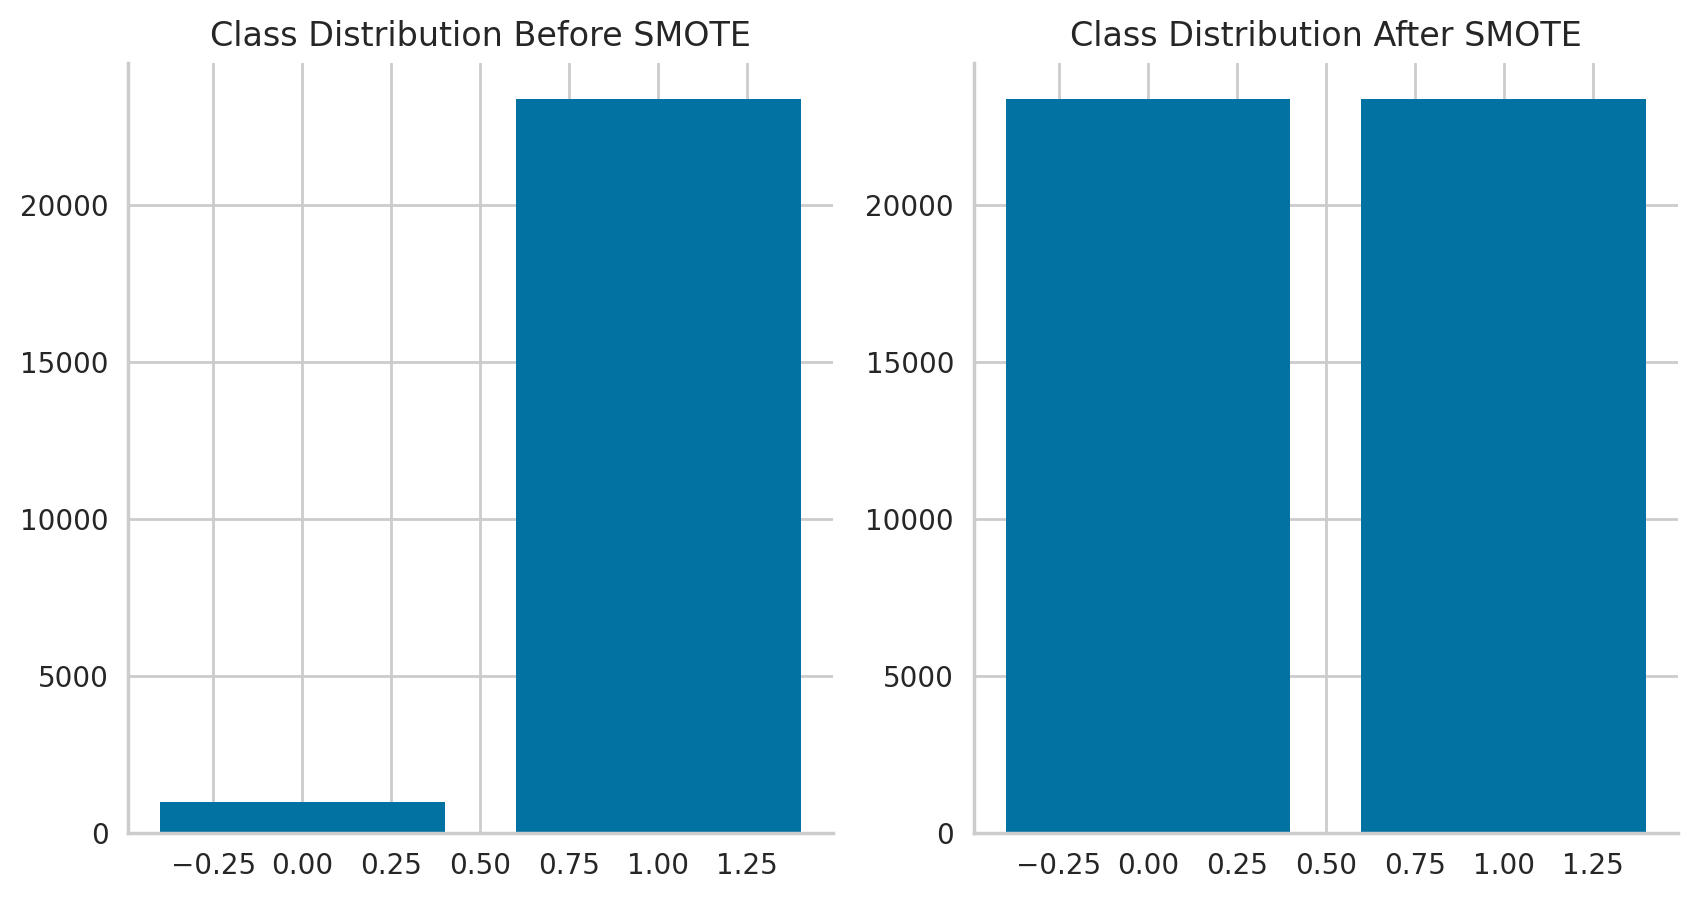

In [28]:
from imblearn.over_sampling import SMOTE
from collections import Counter
#smote 
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after applying SMOTE
print("Class distribution after SMOTE:", Counter(y_resampled))

# Visualize the distribution before and after SMOTE
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(Counter(y_train).keys(), Counter(y_train).values())
plt.title("Class Distribution Before SMOTE")

plt.subplot(1, 2, 2)
plt.bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
plt.title("Class Distribution After SMOTE")

plt.show()

In [29]:
X_train,y_train = X_resampled,y_resampled

#### LogisticRegression

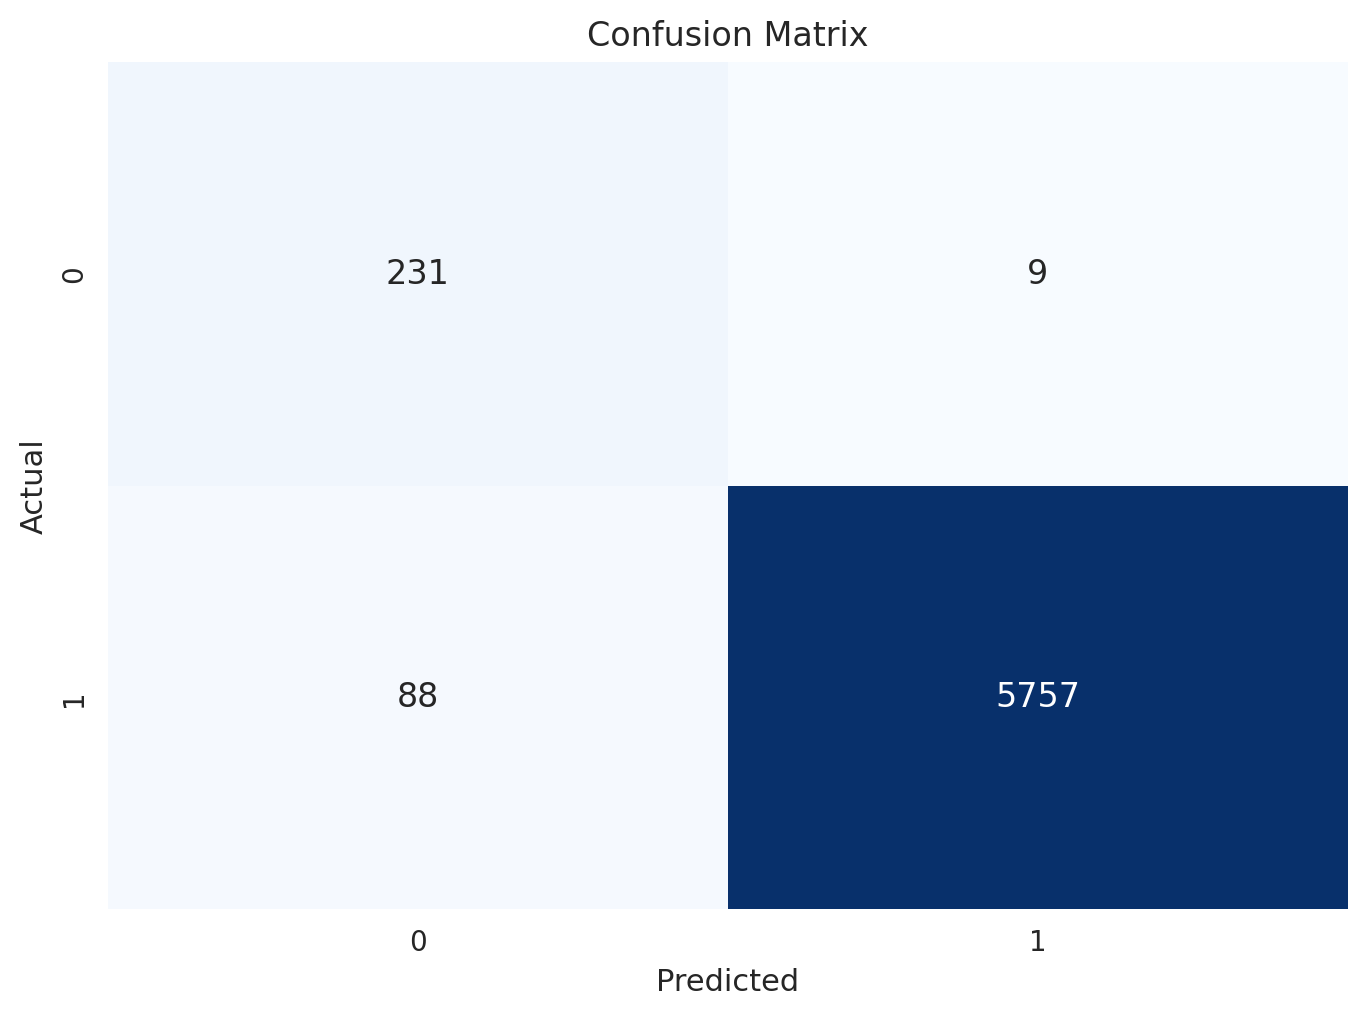

,model,F1 Score,MCC
0,LogisticRegression,0.991646,0.827407


In [30]:
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler

sc=StandardScaler().fit(X_train)
X_train_sc=sc.transform(X_train)
X_test_sc=sc.transform(X_test)

log_reg=LogisticRegression().fit(X_train_sc,y_train)
pred_log=log_reg.predict(X_test_sc)
pred_log_train=log_reg.predict(X_train_sc)
logreg_res=evaluate_preds(y_test, pred_log,'LogisticRegression')
logreg_res
testing = testing._append(pd.Series(logreg_res),ignore_index=True )
testing

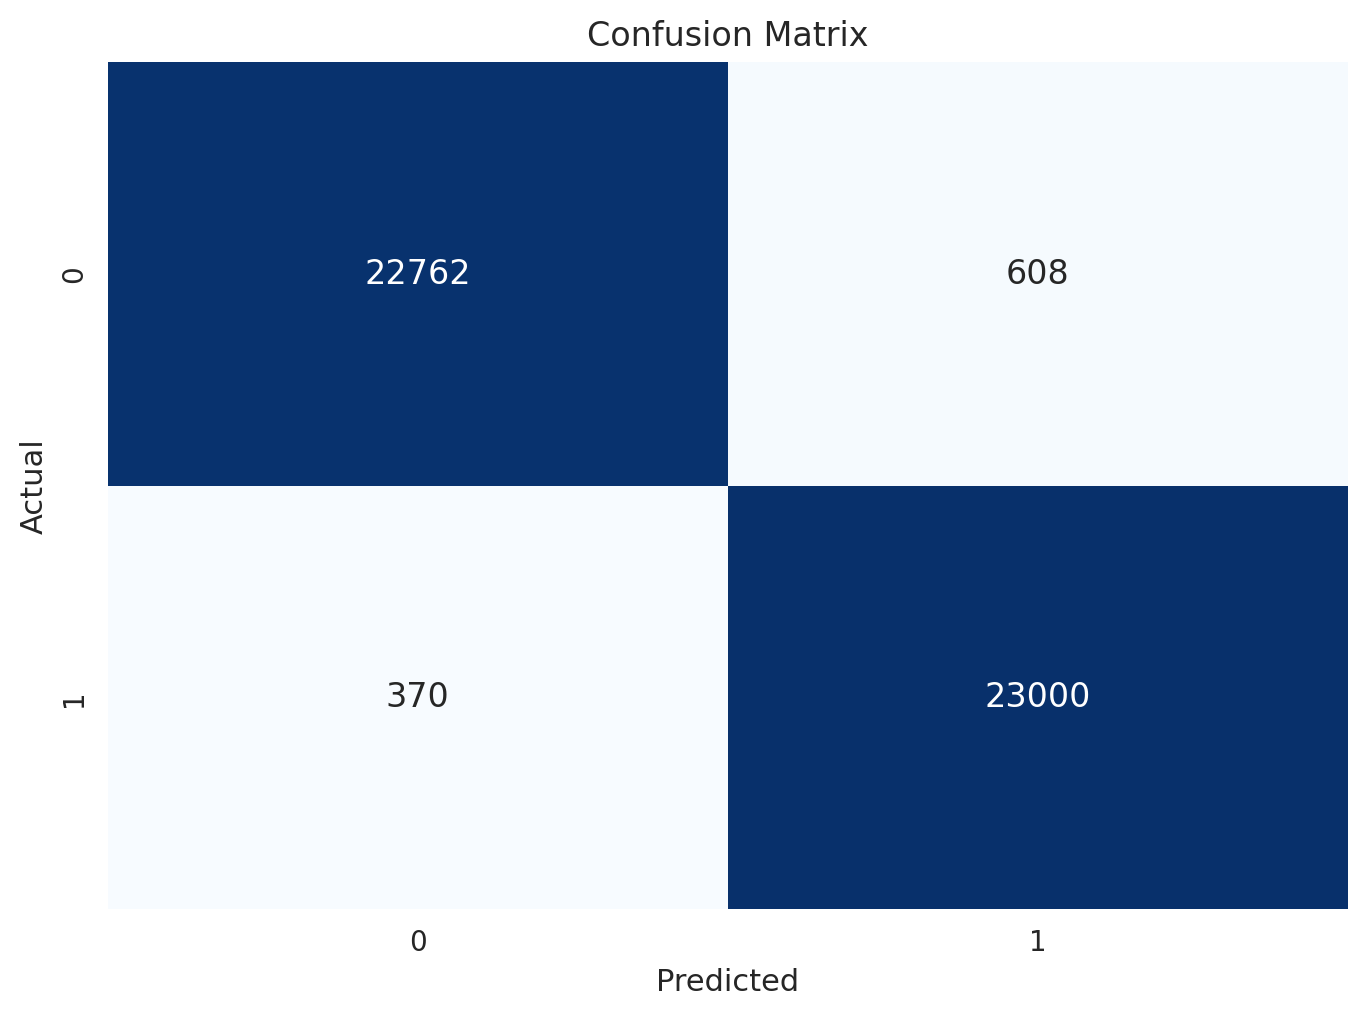

,model,F1 Score,MCC
0,LogisticRegression,0.979182,0.958201


In [31]:
logreg_res=evaluate_preds(y_train, pred_log_train,'LogisticRegression')
logreg_res
training = training._append(pd.Series(logreg_res),ignore_index=True )
training

In [32]:
X_sc=sc.transform(X)
log_proba=log_reg.predict_proba(X_sc)
calculate_apfd_from_probabilities(log_proba)

0.9999636506445504

#### RandomForest

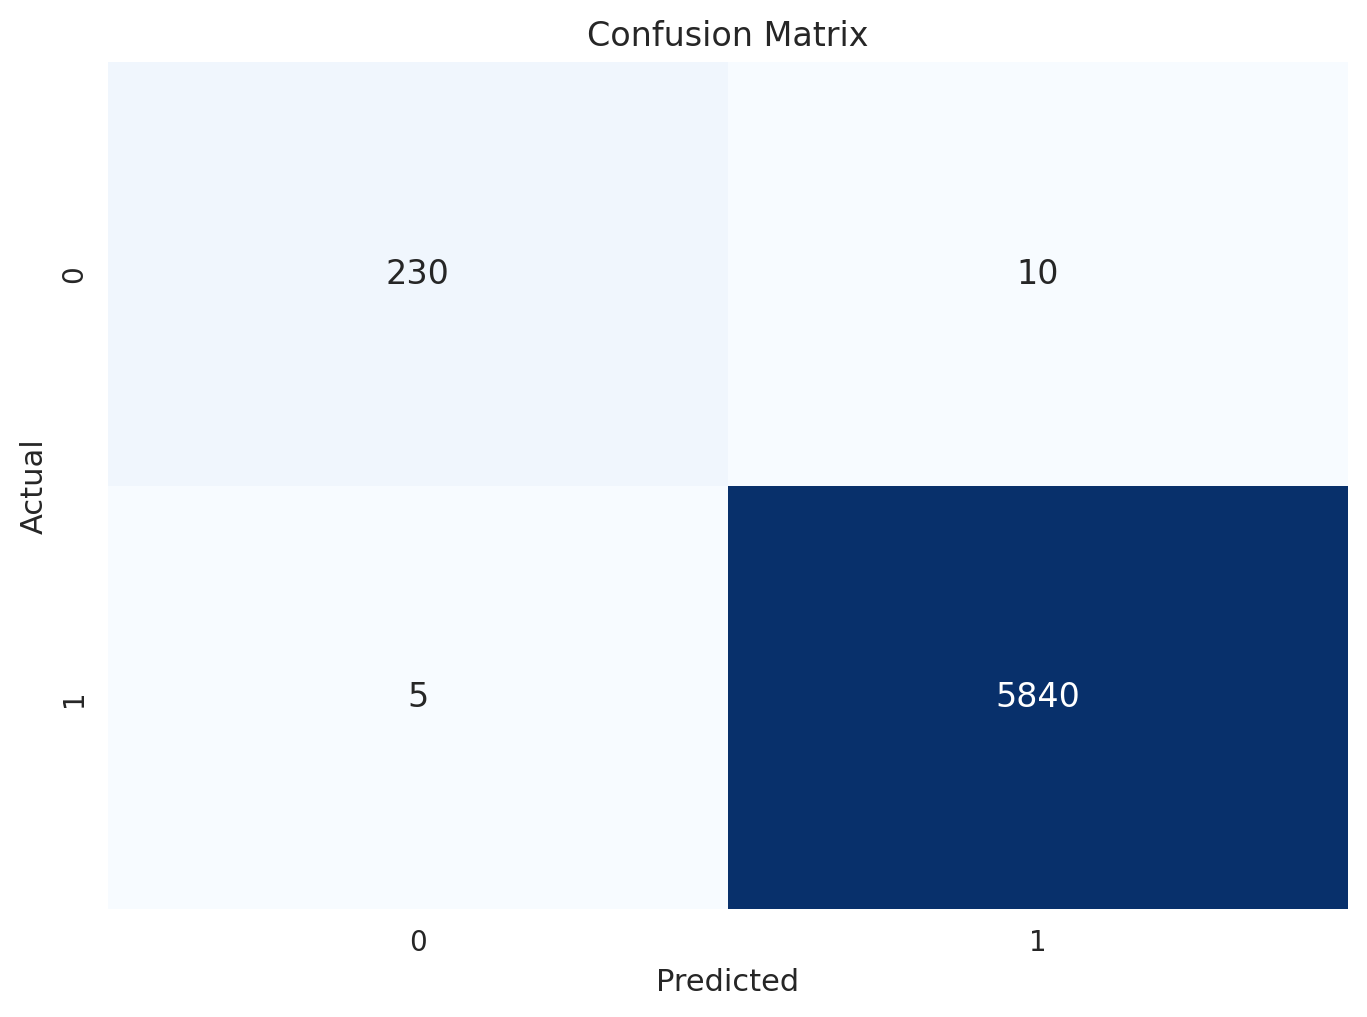

,model,F1 Score,MCC
0,LogisticRegression,0.991646,0.827407
1,RandomForest,0.998717,0.967197


In [33]:
from sklearn.ensemble import RandomForestClassifier


# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
pred_rf = rf_classifier.predict(X_test)
pred_rf_train = rf_classifier.predict(X_train)

# Evaluate the Random Forest model
rf_res = evaluate_preds(y_test, pred_rf, 'RandomForest')


# Append the results to the testing DataFrame (assuming `testing` is a DataFrame)
testing = testing._append(pd.Series(rf_res), ignore_index=True)
testing

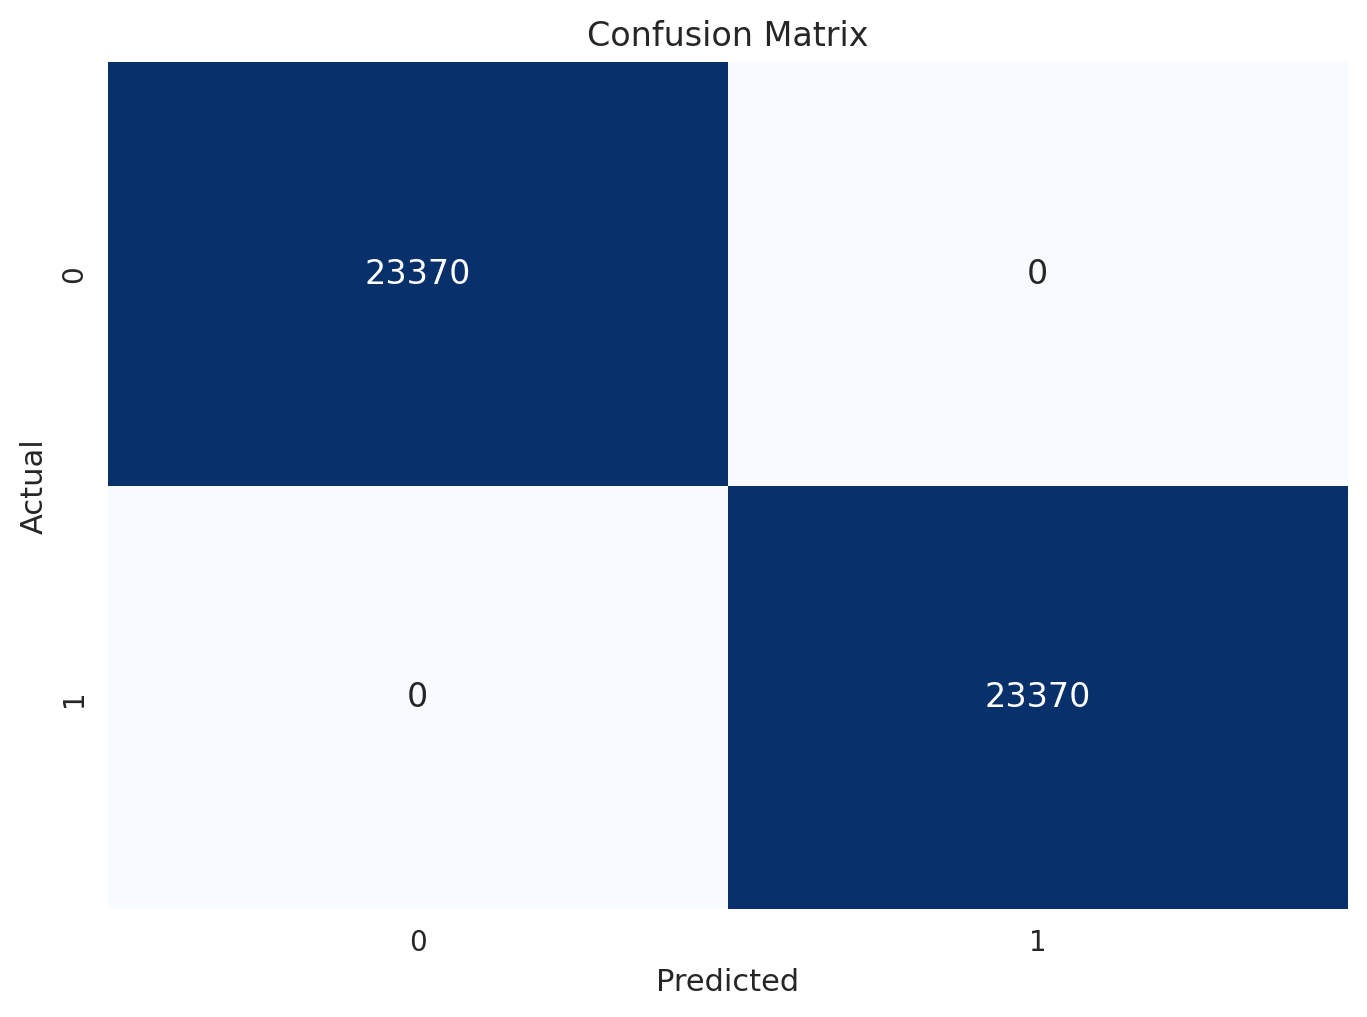

,model,F1 Score,MCC
0,LogisticRegression,0.979182,0.958201
1,RandomForest,1.000000,1.000000


In [34]:
rf_res=evaluate_preds(y_train, pred_rf_train,'RandomForest')
training = training._append(pd.Series(rf_res),ignore_index=True )
training

In [35]:
rf_proba=rf_classifier.predict_proba(X)
calculate_apfd_from_probabilities(rf_proba)

0.9999645299686116

#### NaiveBayes

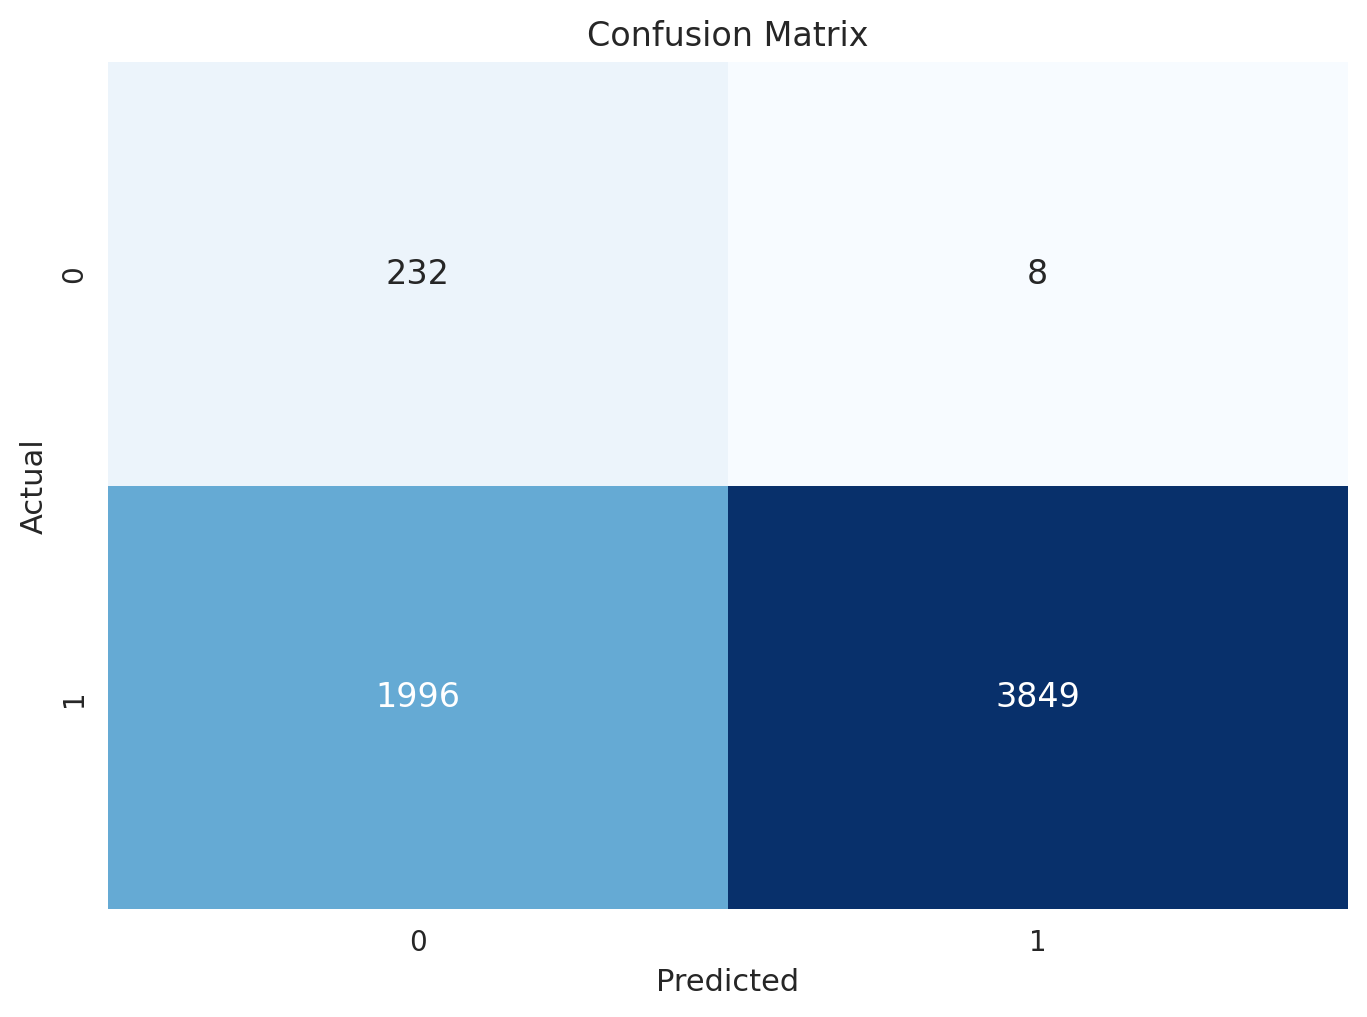

,model,F1 Score,MCC
0,LogisticRegression,0.991646,0.827407
1,RandomForest,0.998717,0.967197
2,NaiveBayes,0.793445,0.252592


In [36]:
from sklearn.naive_bayes import GaussianNB


# Create a Naive Bayes Classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
pred_nb = nb_classifier.predict(X_test)
pred_nb_train = nb_classifier.predict(X_train)

# Evaluate the Naive Bayes model
nb_res = evaluate_preds(y_test, pred_nb, 'NaiveBayes')


# Append the results to the testing DataFrame (assuming `testing` is a DataFrame)
testing = testing._append(pd.Series(nb_res), ignore_index=True)
testing

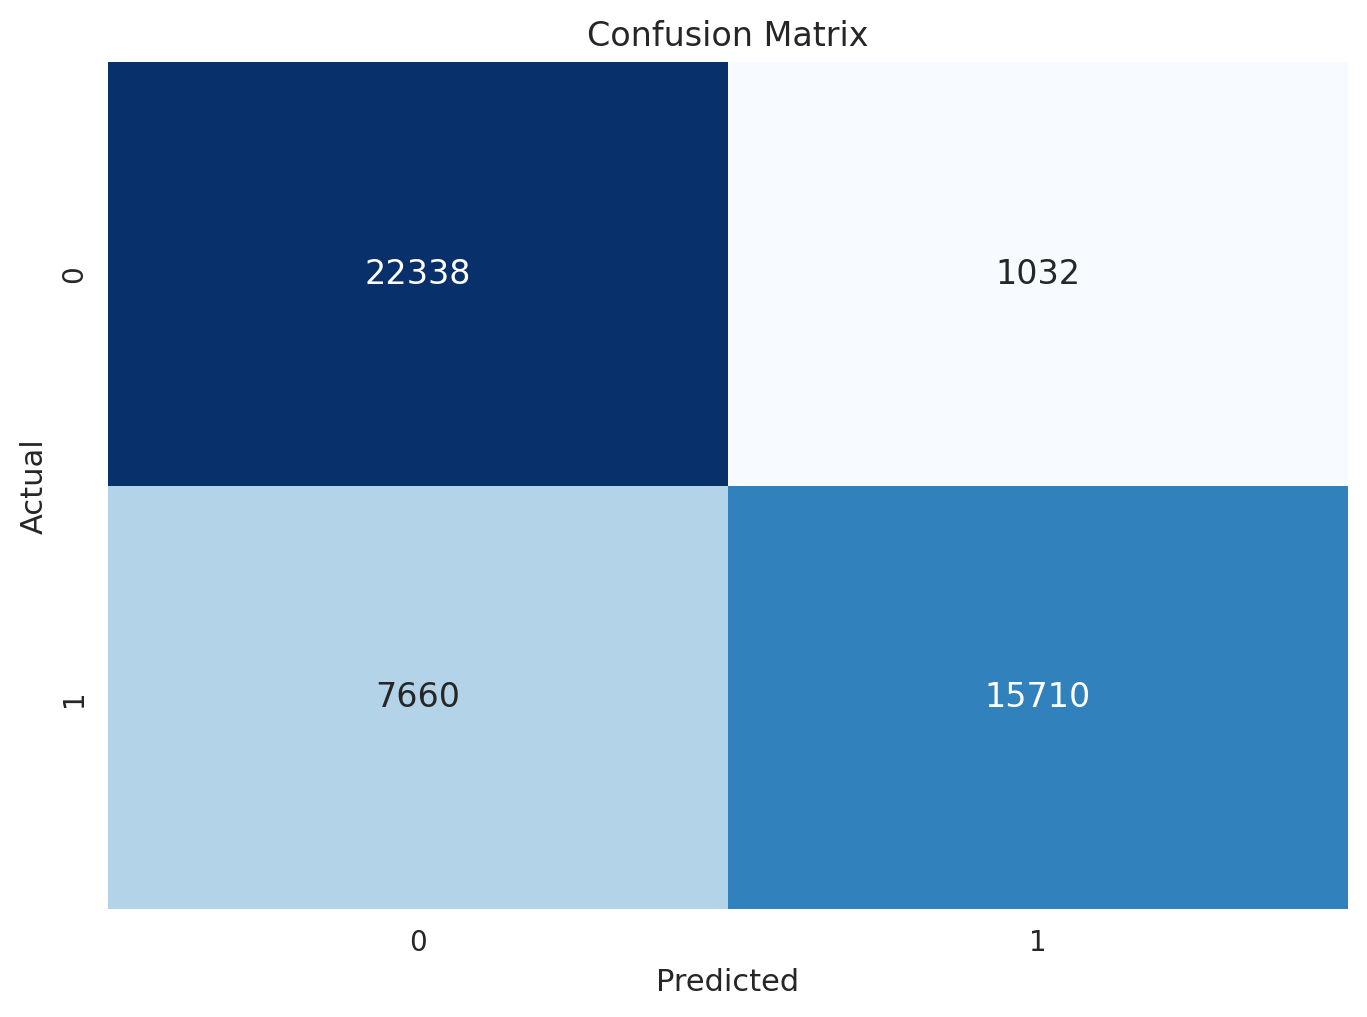

,model,F1 Score,MCC
0,LogisticRegression,0.979182,0.958201
1,RandomForest,1.000000,1.000000
2,NaiveBayes,0.783307,0.654963


In [37]:
nb_res=evaluate_preds(y_train, pred_nb_train, 'NaiveBayes')
training = training._append(pd.Series(nb_res),ignore_index=True )
training

In [38]:
nb_proba=nb_classifier.predict_proba(X)
calculate_apfd_from_probabilities(nb_proba)

0.9999437934763769

#### xgboost

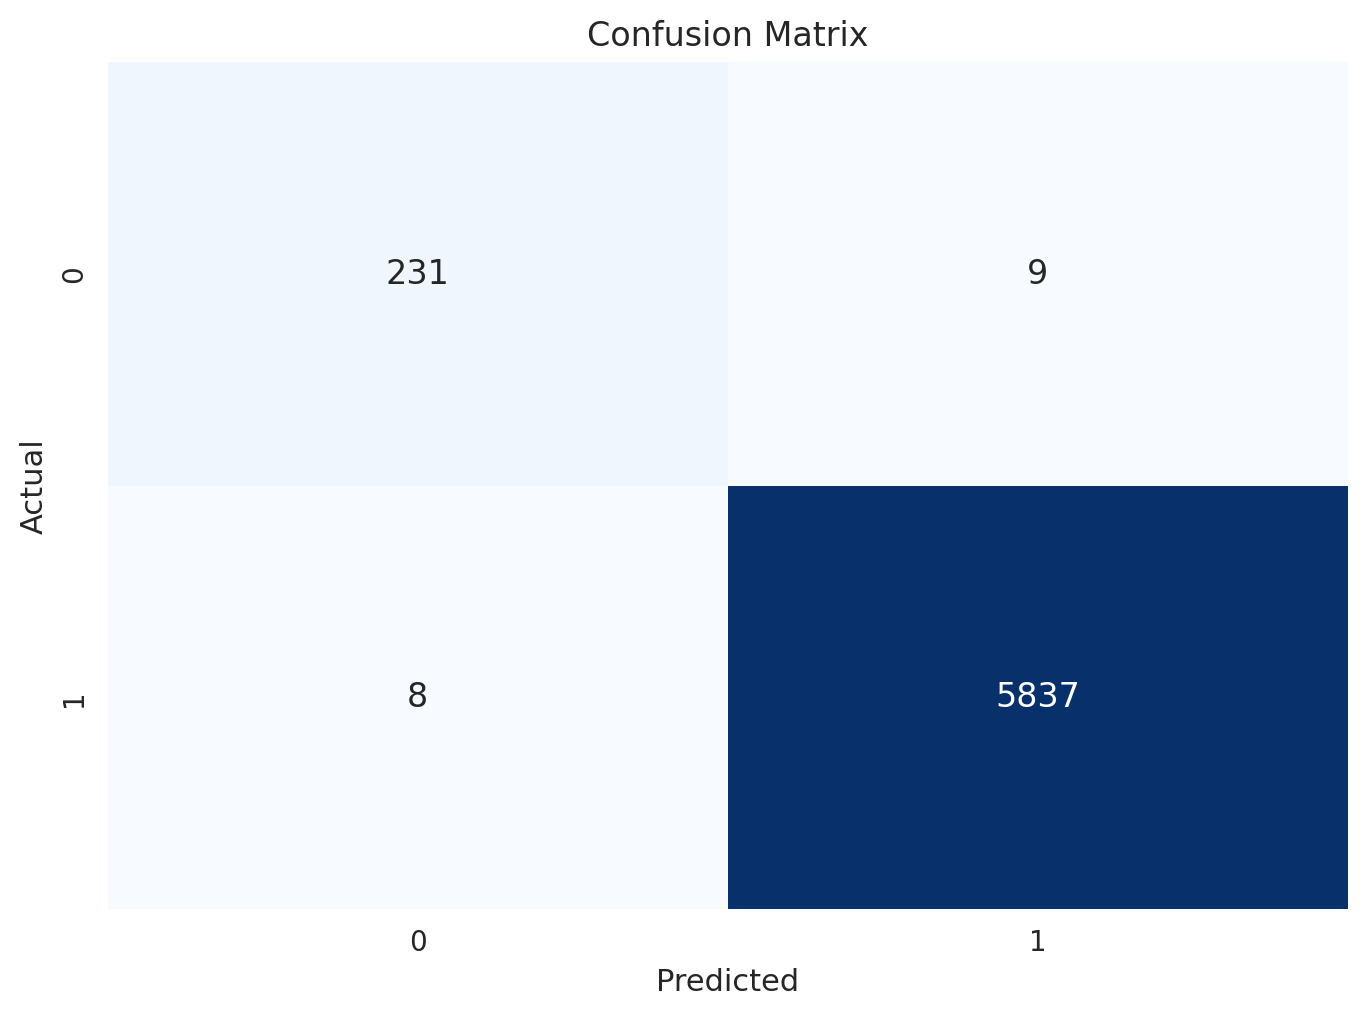

,model,F1 Score,MCC
0,LogisticRegression,0.991646,0.827407
1,RandomForest,0.998717,0.967197
2,NaiveBayes,0.793445,0.252592
3,XGBoost,0.998546,0.963058


In [39]:
import xgboost as xgb

# Create a XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
pred_xgb = xgb_classifier.predict(X_test)
pred_xgb_train = xgb_classifier.predict(X_train)

# Evaluate the XGBoost model
xgb_res = evaluate_preds(y_test, pred_xgb, 'XGBoost')


# Append the results to the testing DataFrame (assuming `testing` is a DataFrame)
testing = testing._append(pd.Series(xgb_res), ignore_index=True)
testing

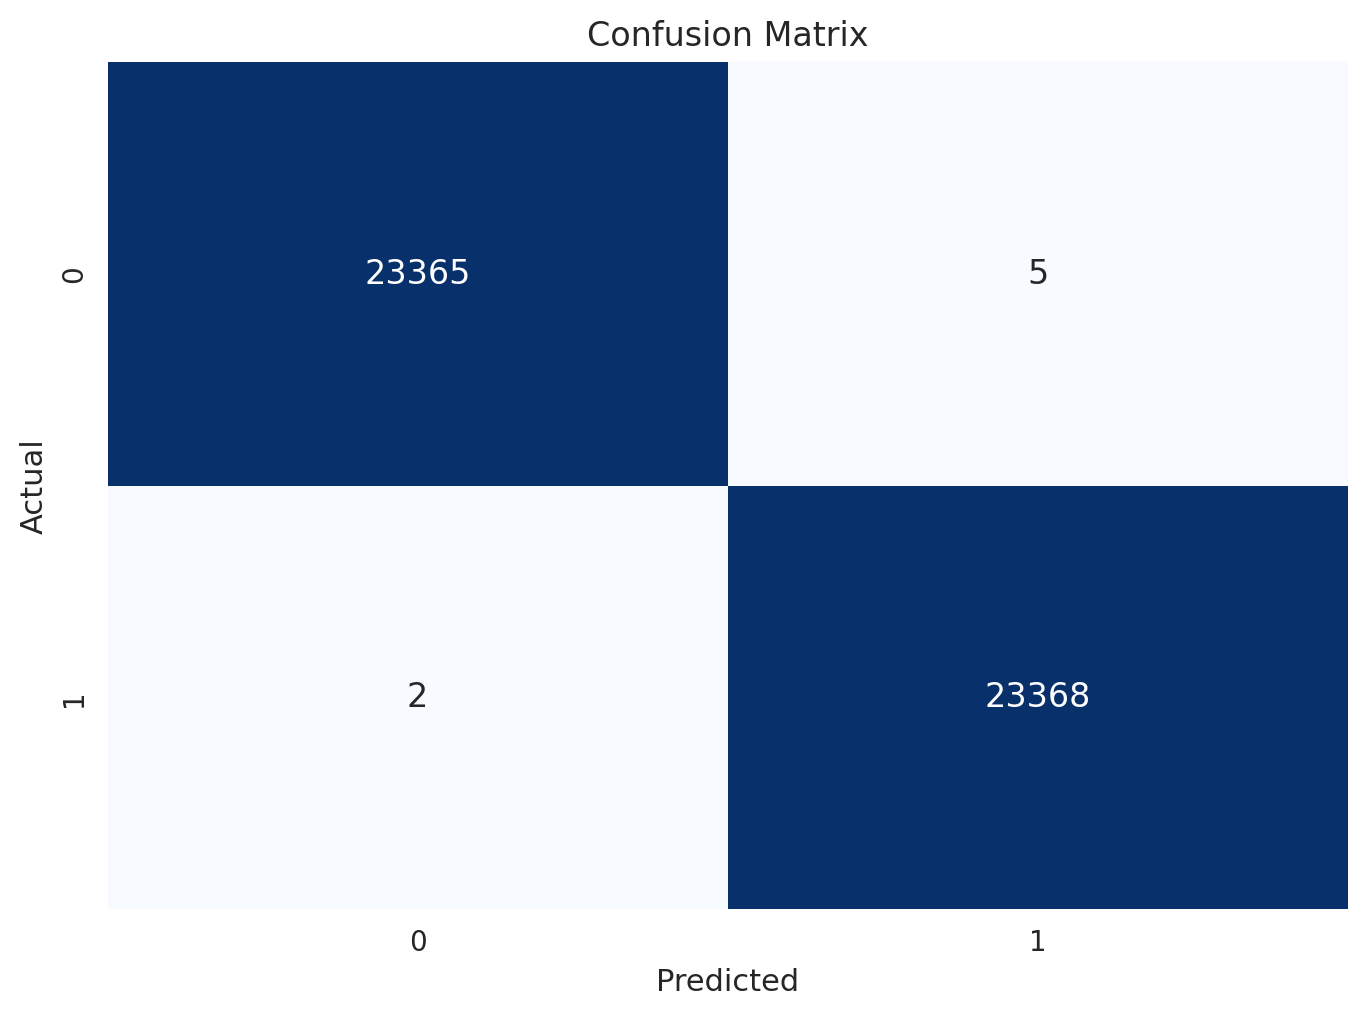

,model,F1 Score,MCC
0,LogisticRegression,0.979182,0.958201
1,RandomForest,1.000000,1.000000
2,NaiveBayes,0.783307,0.654963
3,XGBoost,0.999850,0.999700


In [40]:
xgb_res = evaluate_preds(y_train, pred_xgb_train, 'XGBoost')
training = training._append(pd.Series(xgb_res),ignore_index=True )
training

In [41]:
xgb_proba=xgb_classifier.predict_proba(X)
calculate_apfd_from_probabilities(xgb_proba)

0.9999645278081103

Learning rate set to 0.053197
0:	learn: 0.5762426	total: 27.1ms	remaining: 27.1s
50:	learn: 0.0283947	total: 1.13s	remaining: 21.1s
100:	learn: 0.0180690	total: 2.07s	remaining: 18.4s
150:	learn: 0.0134621	total: 3.03s	remaining: 17s
200:	learn: 0.0114266	total: 3.93s	remaining: 15.6s
250:	learn: 0.0104437	total: 4.82s	remaining: 14.4s
300:	learn: 0.0098312	total: 5.58s	remaining: 13s
350:	learn: 0.0098312	total: 6.24s	remaining: 11.5s
400:	learn: 0.0098312	total: 6.89s	remaining: 10.3s
450:	learn: 0.0098312	total: 7.54s	remaining: 9.18s
500:	learn: 0.0098312	total: 8.21s	remaining: 8.18s
550:	learn: 0.0098312	total: 8.88s	remaining: 7.24s
600:	learn: 0.0098312	total: 9.54s	remaining: 6.33s
650:	learn: 0.0097733	total: 10.2s	remaining: 5.47s
700:	learn: 0.0092913	total: 11s	remaining: 4.67s
750:	learn: 0.0090381	total: 11.7s	remaining: 3.87s
800:	learn: 0.0090380	total: 12.3s	remaining: 3.06s
850:	learn: 0.0090380	total: 13s	remaining: 2.27s
900:	learn: 0.0090380	total: 13.6s	remaining

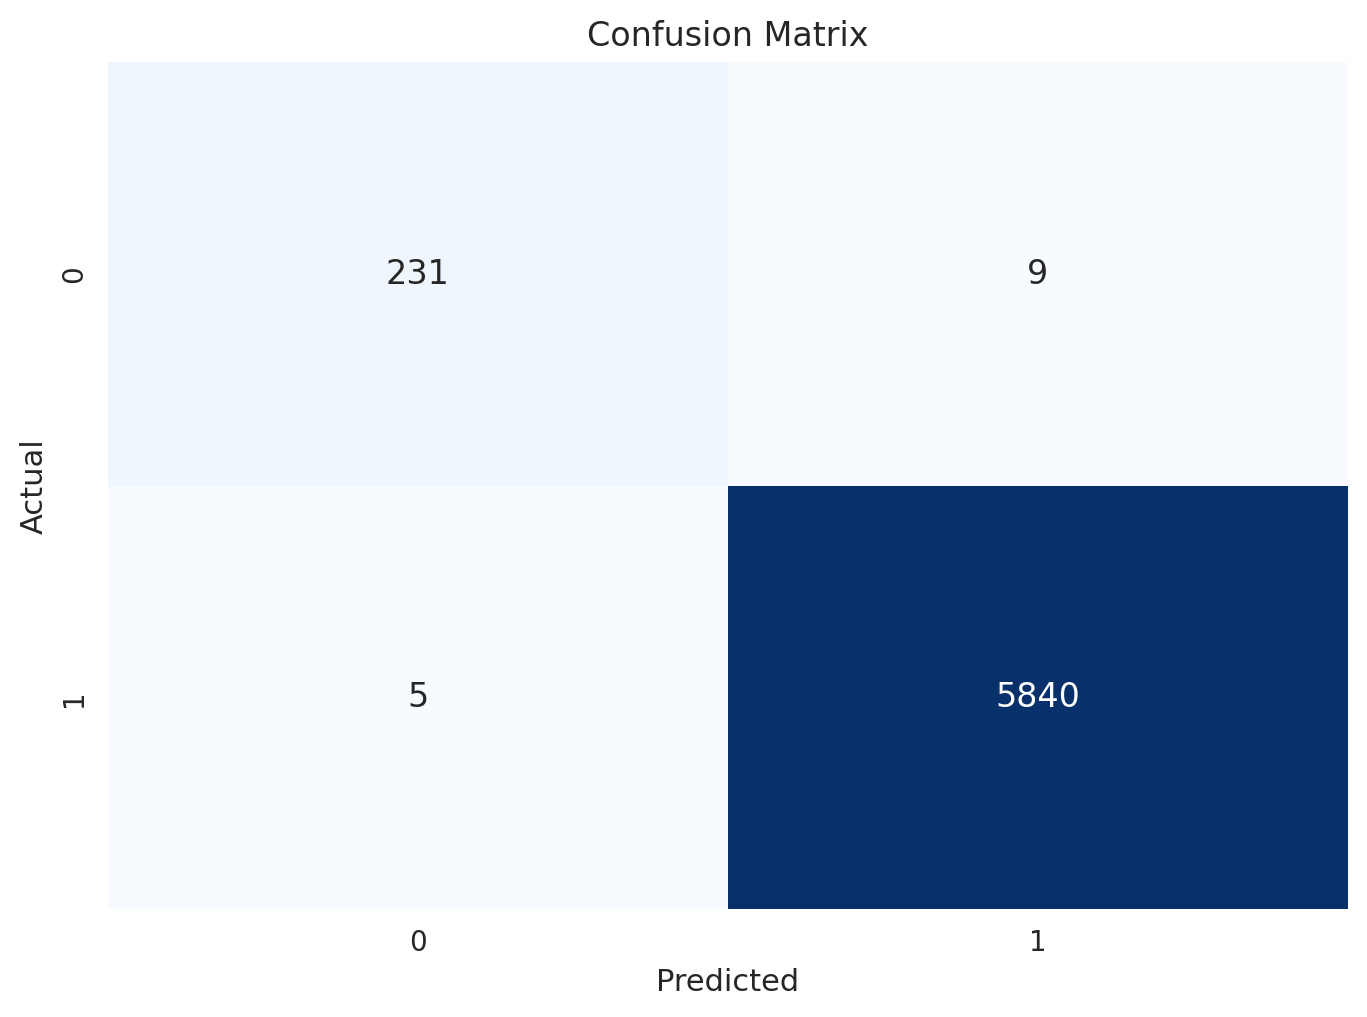

,model,F1 Score,MCC
0,LogisticRegression,0.991646,0.827407
1,RandomForest,0.998717,0.967197
2,NaiveBayes,0.793445,0.252592
3,XGBoost,0.998546,0.963058
4,CatBoost,0.998803,0.969428


In [42]:
import catboost as cb

# Create a CatBoost Classifier
catboost_classifier = cb.CatBoostClassifier(random_state=42)
catboost_classifier.fit(X_train, y_train,verbose=50)

# Make predictions on the test set
pred_catboost = catboost_classifier.predict(X_test)
pred_catboost_train = catboost_classifier.predict(X_train)

# Evaluate the CatBoost model
catboost_res = evaluate_preds(y_test, pred_catboost, 'CatBoost')

# Append the results to the testing DataFrame (assuming `testing` is a DataFrame)
testing = testing.append(pd.Series(catboost_res), ignore_index=True)
testing


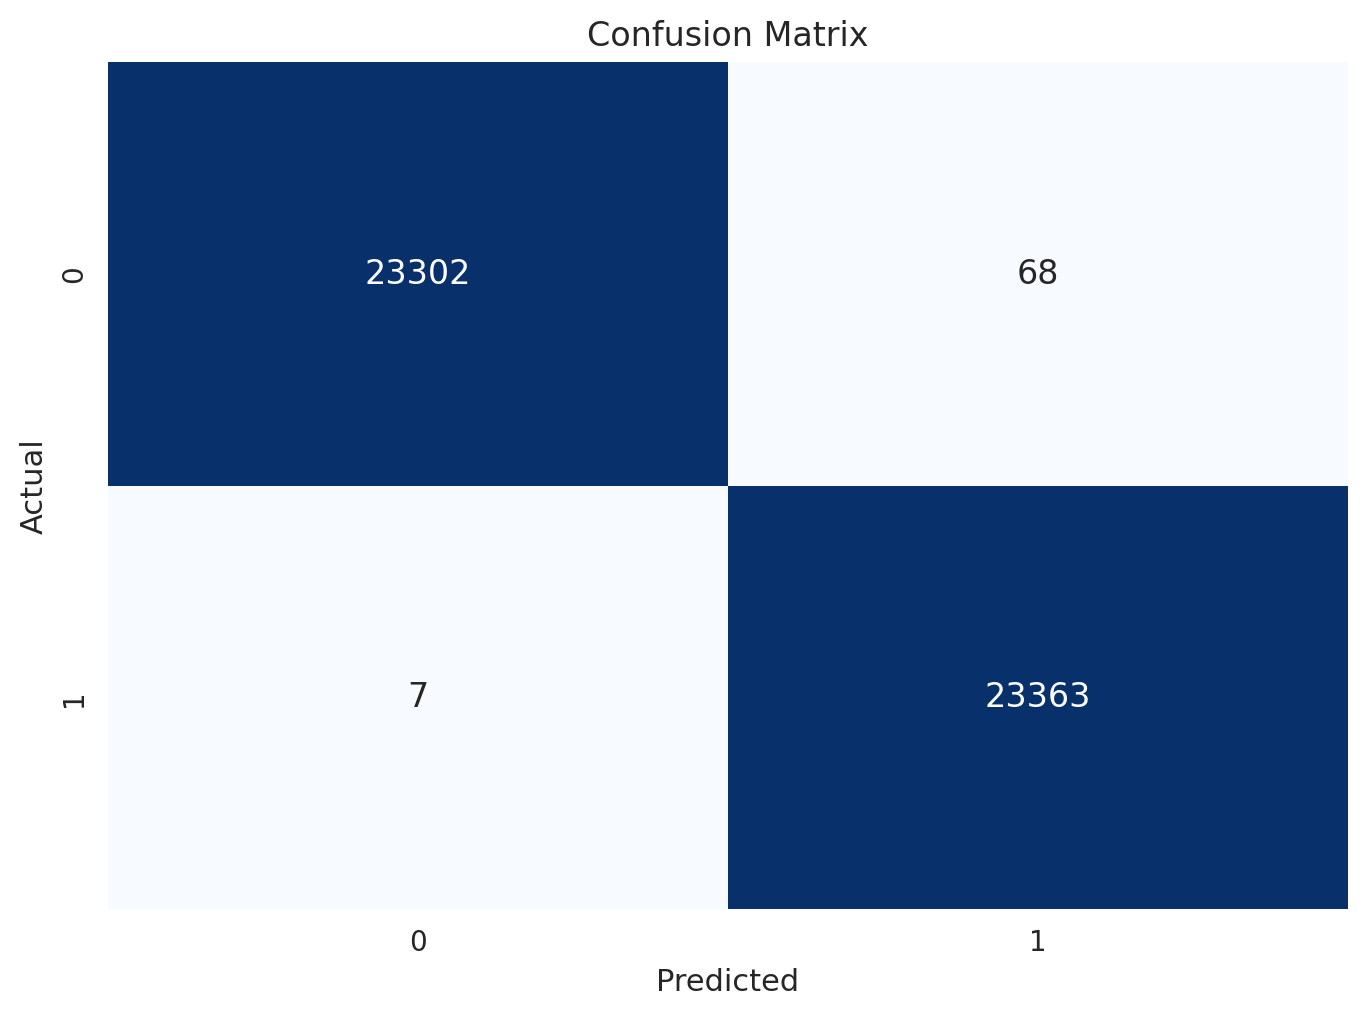

,model,F1 Score,MCC
0,LogisticRegression,0.979182,0.958201
1,RandomForest,1.000000,1.000000
2,NaiveBayes,0.783307,0.654963
3,XGBoost,0.999850,0.999700
4,catboost,0.998397,0.996794


In [43]:
cat_res = evaluate_preds(y_train, pred_catboost_train, 'catboost')
training = training._append(pd.Series(cat_res),ignore_index=True )
training

#### ligtgbm

[LightGBM] [Info] Number of positive: 23370, number of negative: 23370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16285
[LightGBM] [Info] Number of data points in the train set: 46740, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


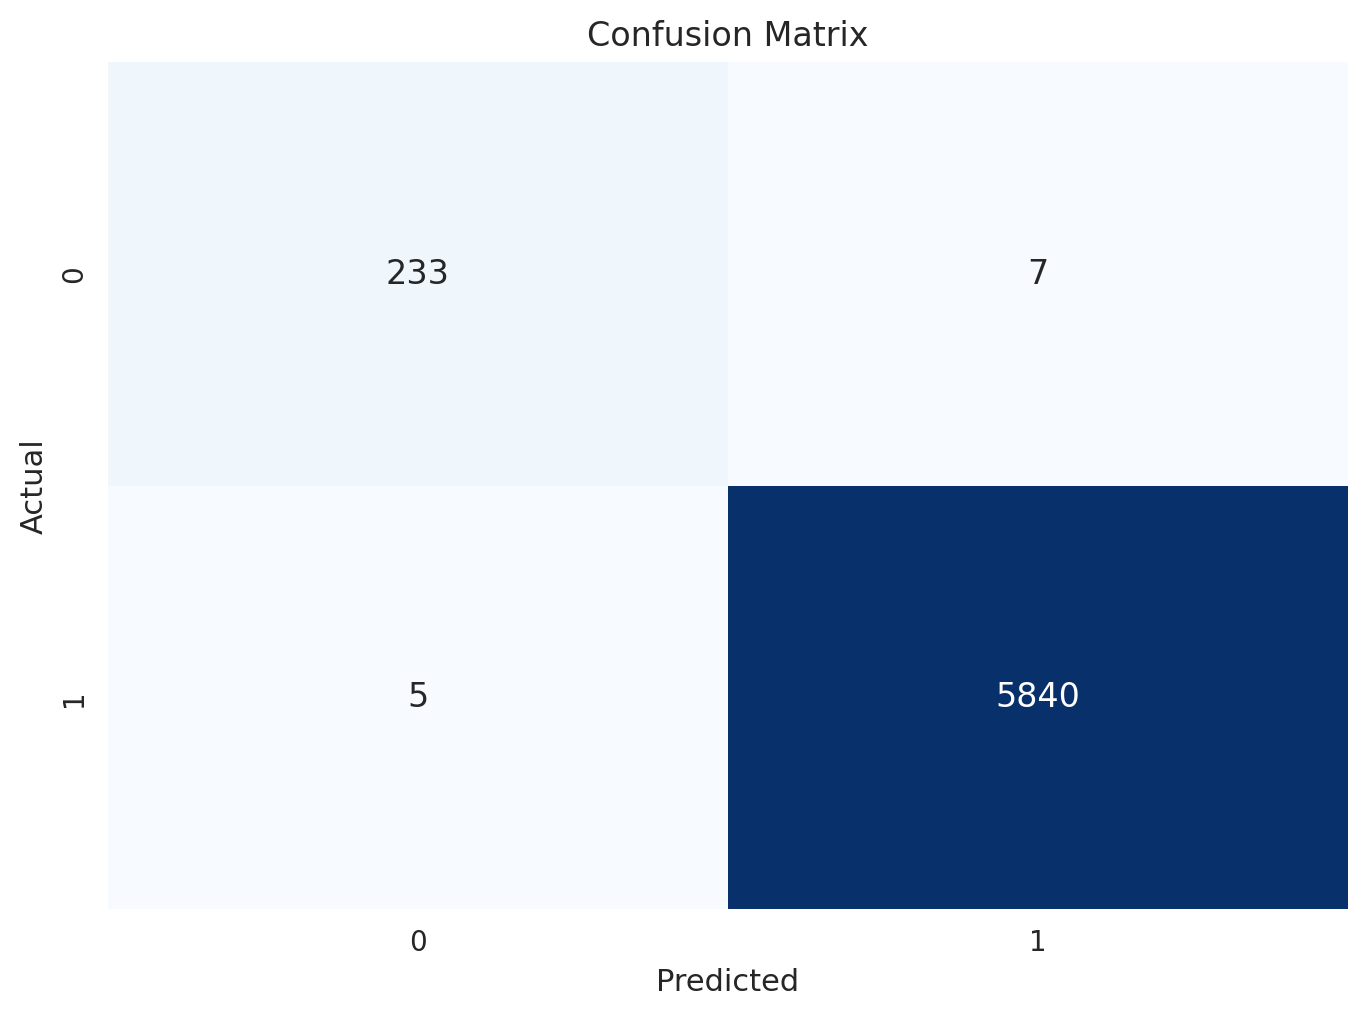

In [44]:
import lightgbm as lgb
# Create a LightGBM Classifier
lgb_classifier = lgb.LGBMClassifier(random_state=42)
lgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
pred_lgb = lgb_classifier.predict(X_test)
pred_lgb_train = lgb_classifier.predict(X_train)

# Evaluate the LightGBM model
lgb_res = evaluate_preds(y_test, pred_lgb, 'LightGBM')

# Append the results to the testing DataFrame (assuming `testing` is a DataFrame)
testing = testing.append(pd.Series(lgb_res), ignore_index=True)

In [45]:
testing

,model,F1 Score,MCC
0,LogisticRegression,0.991646,0.827407
1,RandomForest,0.998717,0.967197
2,NaiveBayes,0.793445,0.252592
3,XGBoost,0.998546,0.963058
4,CatBoost,0.998803,0.969428
5,LightGBM,0.998974,0.973878


[LightGBM] [Info] Number of positive: 23370, number of negative: 970
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18945
[LightGBM] [Info] Number of data points in the train set: 24340, number of used features: 152
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.960148 -> initscore=3.181912
[LightGBM] [Info] Start training from score 3.181912


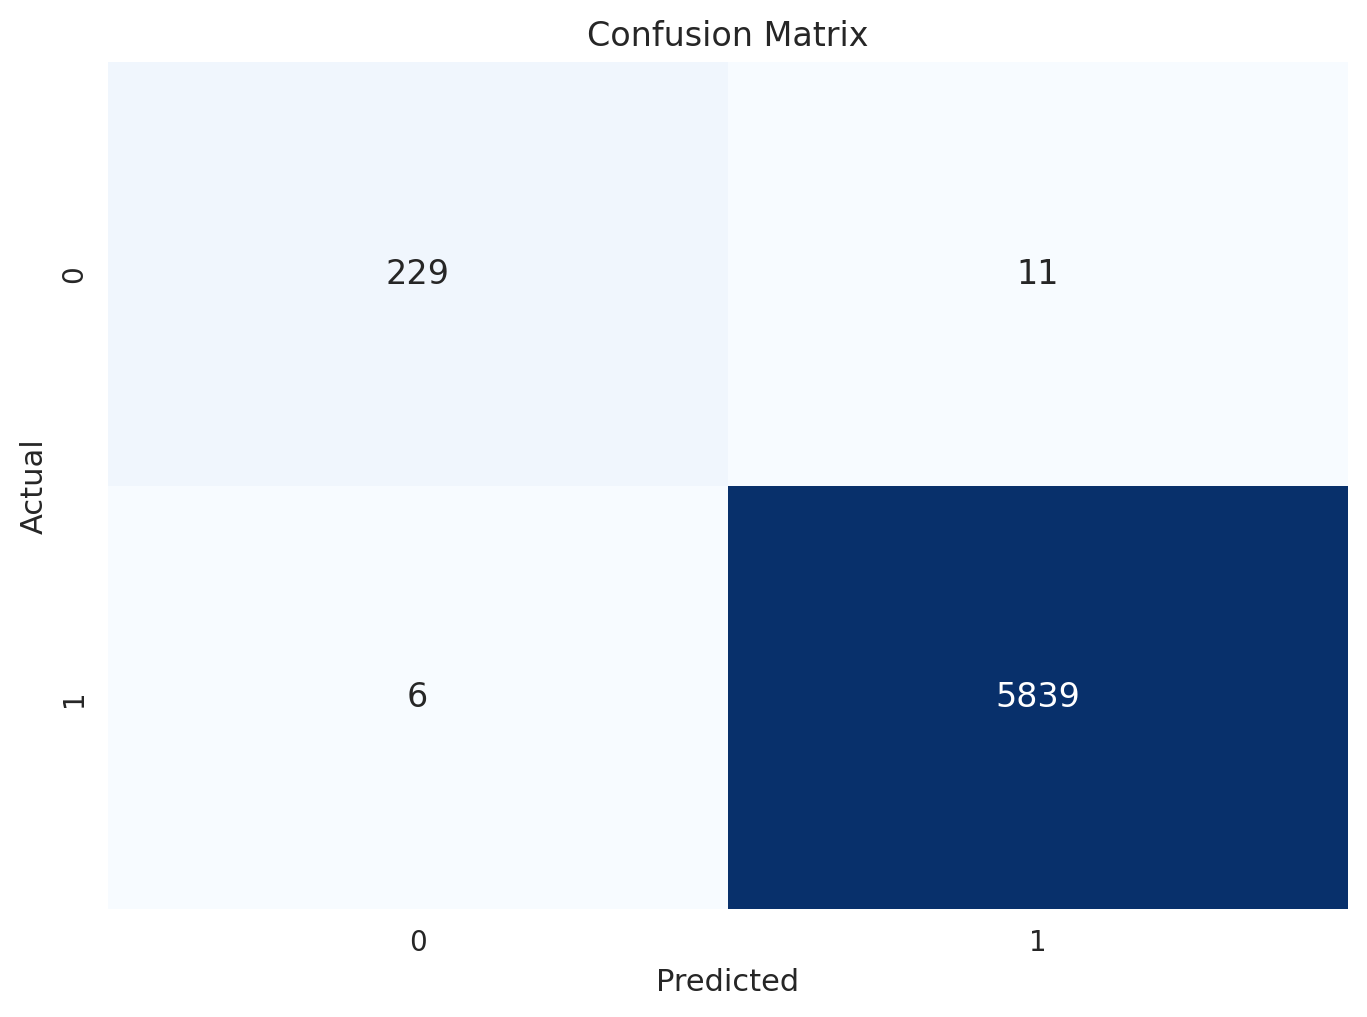

{'model': 'LightGBM',
 'F1 Score': 0.9985463873450192,
 'MCC': 0.9628148450189157}

In [46]:
# compare without sote and feature selection
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
data.drop('Verdict',axis=1), data['Verdict'], test_size=0.2, random_state=42)

lgb_classifier = lgb.LGBMClassifier(random_state=42)
lgb_classifier.fit(Xf_train, yf_train)

# Make predictions on the test set
pred_lgb = lgb_classifier.predict(Xf_test)
pred_lgb_train = lgb_classifier.predict(Xf_train)

# Evaluate the LightGBM model
lgb_res = evaluate_preds(y_test, pred_lgb, 'LightGBM')
lgb_res

### hyperparameter tuning

In [47]:
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

def objective(trial, X_train, y_train, X_val, y_val):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = lgb.LGBMClassifier(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = matthews_corrcoef(y_val, y_pred)
    return accuracy

def optimize_lgbm(X, y, n_trials=100):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    study = optuna.create_study(direction='maximize')
    objective_fn = lambda trial: objective(trial, X_train, y_train, X_val, y_val)
    study.optimize(objective_fn, n_trials=n_trials)

    best_params = study.best_params
    best_model = lgb.LGBMClassifier(**best_params)
    best_model.fit(X_train, y_train)

    return best_model, best_params

In [48]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
best_model, best_params = optimize_lgbm(X_resampled, y_resampled, n_trials=100)
best_params

[I 2024-02-17 15:33:14,568] A new study created in memory with name: no-name-6e13a167-8a1b-49e9-bbe2-081977810278


[LightGBM] [Warning] feature_fraction is set=0.6477044646274206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6477044646274206
[LightGBM] [Warning] bagging_fraction is set=0.6736376221763987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736376221763987
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6477044646274206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6477044646274206
[LightGBM] [Warning] bagging_fraction is set=0.6736376221763987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736376221763987
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049823 seconds.
You can

[I 2024-02-17 15:33:20,009] Trial 0 finished with value: 0.9861941867521979 and parameters: {'num_leaves': 292, 'learning_rate': 0.009292451494397436, 'feature_fraction': 0.6477044646274206, 'bagging_fraction': 0.6736376221763987, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 0 with value: 0.9861941867521979.


[LightGBM] [Warning] feature_fraction is set=0.4233903669189635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4233903669189635
[LightGBM] [Warning] bagging_fraction is set=0.9078784292844964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9078784292844964
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4233903669189635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4233903669189635
[LightGBM] [Warning] bagging_fraction is set=0.9078784292844964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9078784292844964
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015671 seconds.
You can

[I 2024-02-17 15:33:26,042] Trial 1 finished with value: 0.989928516275772 and parameters: {'num_leaves': 497, 'learning_rate': 0.009061470793345357, 'feature_fraction': 0.4233903669189635, 'bagging_fraction': 0.9078784292844964, 'bagging_freq': 8, 'min_child_samples': 47}. Best is trial 1 with value: 0.989928516275772.


[LightGBM] [Warning] feature_fraction is set=0.5556689176928277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5556689176928277
[LightGBM] [Warning] bagging_fraction is set=0.2994062701803245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2994062701803245
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5556689176928277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5556689176928277
[LightGBM] [Warning] bagging_fraction is set=0.2994062701803245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2994062701803245
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019363 seconds.
You can

[I 2024-02-17 15:33:28,895] Trial 2 finished with value: 0.9747180145018708 and parameters: {'num_leaves': 132, 'learning_rate': 0.004611453295868133, 'feature_fraction': 0.5556689176928277, 'bagging_fraction': 0.2994062701803245, 'bagging_freq': 5, 'min_child_samples': 67}. Best is trial 1 with value: 0.989928516275772.


[LightGBM] [Warning] feature_fraction is set=0.5556689176928277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5556689176928277
[LightGBM] [Warning] bagging_fraction is set=0.2994062701803245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2994062701803245
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.36950167192216643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36950167192216643
[LightGBM] [Warning] bagging_fraction is set=0.3071951201869624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3071951201869624
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.36950167192216643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36950167192216643
[LightGBM] [Warning] bag

[I 2024-02-17 15:33:32,099] Trial 3 finished with value: 0.9752927006376012 and parameters: {'num_leaves': 885, 'learning_rate': 0.002624228137063965, 'feature_fraction': 0.36950167192216643, 'bagging_fraction': 0.3071951201869624, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 1 with value: 0.989928516275772.


[LightGBM] [Warning] feature_fraction is set=0.8006588797922811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8006588797922811
[LightGBM] [Warning] bagging_fraction is set=0.6384082063518094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6384082063518094
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8006588797922811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8006588797922811
[LightGBM] [Warning] bagging_fraction is set=0.6384082063518094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6384082063518094
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050163 seconds.
You can

[I 2024-02-17 15:33:38,031] Trial 4 finished with value: 0.980112029516193 and parameters: {'num_leaves': 945, 'learning_rate': 0.001308102491967929, 'feature_fraction': 0.8006588797922811, 'bagging_fraction': 0.6384082063518094, 'bagging_freq': 8, 'min_child_samples': 67}. Best is trial 1 with value: 0.989928516275772.


[LightGBM] [Warning] feature_fraction is set=0.6204479910840337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6204479910840337
[LightGBM] [Warning] bagging_fraction is set=0.30147122960939393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30147122960939393
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6204479910840337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6204479910840337
[LightGBM] [Warning] bagging_fraction is set=0.30147122960939393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30147122960939393
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053134 seconds.
You

[I 2024-02-17 15:33:41,284] Trial 5 finished with value: 0.9809883441666056 and parameters: {'num_leaves': 191, 'learning_rate': 0.011288188069471, 'feature_fraction': 0.6204479910840337, 'bagging_fraction': 0.30147122960939393, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 1 with value: 0.989928516275772.


[LightGBM] [Warning] feature_fraction is set=0.3326872262396894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3326872262396894
[LightGBM] [Warning] bagging_fraction is set=0.471332199798441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.471332199798441
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.3326872262396894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3326872262396894
[LightGBM] [Warning] bagging_fraction is set=0.471332199798441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.471332199798441
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013741 seconds.
You can set

[I 2024-02-17 15:33:44,806] Trial 6 finished with value: 0.9793635370711622 and parameters: {'num_leaves': 366, 'learning_rate': 0.00909017815643423, 'feature_fraction': 0.3326872262396894, 'bagging_fraction': 0.471332199798441, 'bagging_freq': 2, 'min_child_samples': 60}. Best is trial 1 with value: 0.989928516275772.


[LightGBM] [Warning] feature_fraction is set=0.6185983064733597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6185983064733597
[LightGBM] [Warning] bagging_fraction is set=0.24935056666807218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24935056666807218
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6185983064733597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6185983064733597
[LightGBM] [Warning] bagging_fraction is set=0.24935056666807218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24935056666807218
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048838 seconds.
You

[I 2024-02-17 15:33:49,076] Trial 7 finished with value: 0.9960664144601425 and parameters: {'num_leaves': 432, 'learning_rate': 0.0780803138874848, 'feature_fraction': 0.6185983064733597, 'bagging_fraction': 0.24935056666807218, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 7 with value: 0.9960664144601425.


[LightGBM] [Warning] feature_fraction is set=0.2706597894964931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2706597894964931
[LightGBM] [Warning] bagging_fraction is set=0.8486915295889214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486915295889214
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2706597894964931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2706597894964931
[LightGBM] [Warning] bagging_fraction is set=0.8486915295889214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486915295889214
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036599 seconds.
You can

[I 2024-02-17 15:33:52,804] Trial 8 finished with value: 0.989060485365566 and parameters: {'num_leaves': 922, 'learning_rate': 0.024075032870691657, 'feature_fraction': 0.2706597894964931, 'bagging_fraction': 0.8486915295889214, 'bagging_freq': 6, 'min_child_samples': 97}. Best is trial 7 with value: 0.9960664144601425.


[LightGBM] [Warning] feature_fraction is set=0.971272600956024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.971272600956024
[LightGBM] [Warning] bagging_fraction is set=0.8021904945589289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8021904945589289
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.971272600956024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.971272600956024
[LightGBM] [Warning] bagging_fraction is set=0.8021904945589289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8021904945589289
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027860 seconds.
You can set

[I 2024-02-17 15:33:58,889] Trial 9 finished with value: 0.9875672239739722 and parameters: {'num_leaves': 346, 'learning_rate': 0.017948271486647183, 'feature_fraction': 0.971272600956024, 'bagging_fraction': 0.8021904945589289, 'bagging_freq': 9, 'min_child_samples': 94}. Best is trial 7 with value: 0.9960664144601425.


[LightGBM] [Warning] feature_fraction is set=0.8384828821388344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8384828821388344
[LightGBM] [Warning] bagging_fraction is set=0.10539045439719238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10539045439719238
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8384828821388344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8384828821388344
[LightGBM] [Warning] bagging_fraction is set=0.10539045439719238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10539045439719238
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050102 seconds.
You

[I 2024-02-17 15:34:04,240] Trial 10 finished with value: 0.992818086649186 and parameters: {'num_leaves': 689, 'learning_rate': 0.07188672032619497, 'feature_fraction': 0.8384828821388344, 'bagging_fraction': 0.10539045439719238, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 7 with value: 0.9960664144601425.


[LightGBM] [Warning] feature_fraction is set=0.8265085570866725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8265085570866725
[LightGBM] [Warning] bagging_fraction is set=0.10132721917121353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10132721917121353
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8265085570866725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8265085570866725
[LightGBM] [Warning] bagging_fraction is set=0.10132721917121353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10132721917121353
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050963 seconds.
You

[I 2024-02-17 15:34:08,617] Trial 11 finished with value: 0.9929945554645603 and parameters: {'num_leaves': 669, 'learning_rate': 0.09269958162541614, 'feature_fraction': 0.8265085570866725, 'bagging_fraction': 0.10132721917121353, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 7 with value: 0.9960664144601425.


[LightGBM] [Warning] feature_fraction is set=0.12195851921628587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12195851921628587
[LightGBM] [Warning] bagging_fraction is set=0.10903615407500272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10903615407500272
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.12195851921628587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12195851921628587
[LightGBM] [Warning] bagging_fraction is set=0.10903615407500272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10903615407500272
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032329 seconds.

[I 2024-02-17 15:34:10,806] Trial 12 finished with value: 0.9916126647166662 and parameters: {'num_leaves': 626, 'learning_rate': 0.0948790759543573, 'feature_fraction': 0.12195851921628587, 'bagging_fraction': 0.10903615407500272, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 7 with value: 0.9960664144601425.


[LightGBM] [Warning] feature_fraction is set=0.7502011578930423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7502011578930423
[LightGBM] [Warning] bagging_fraction is set=0.23007507510053776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23007507510053776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7502011578930423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7502011578930423
[LightGBM] [Warning] bagging_fraction is set=0.23007507510053776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23007507510053776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048894 seconds.
You

[I 2024-02-17 15:34:15,523] Trial 13 finished with value: 0.9929945554645603 and parameters: {'num_leaves': 711, 'learning_rate': 0.04624256997051782, 'feature_fraction': 0.7502011578930423, 'bagging_fraction': 0.23007507510053776, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 7 with value: 0.9960664144601425.


[LightGBM] [Warning] feature_fraction is set=0.9720761292657694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9720761292657694
[LightGBM] [Warning] bagging_fraction is set=0.42775021680167874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42775021680167874
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9720761292657694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9720761292657694
[LightGBM] [Warning] bagging_fraction is set=0.42775021680167874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42775021680167874
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027880 seconds.
You

[I 2024-02-17 15:34:22,360] Trial 14 finished with value: 0.9948697101736321 and parameters: {'num_leaves': 559, 'learning_rate': 0.04153414467606069, 'feature_fraction': 0.9720761292657694, 'bagging_fraction': 0.42775021680167874, 'bagging_freq': 4, 'min_child_samples': 26}. Best is trial 7 with value: 0.9960664144601425.


[LightGBM] [Warning] feature_fraction is set=0.9609405751648873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9609405751648873
[LightGBM] [Warning] bagging_fraction is set=0.4572644301838519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4572644301838519
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9609405751648873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9609405751648873
[LightGBM] [Warning] bagging_fraction is set=0.4572644301838519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4572644301838519
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027953 seconds.
You can

[I 2024-02-17 15:34:24,901] Trial 15 finished with value: 0.9935041214889477 and parameters: {'num_leaves': 36, 'learning_rate': 0.038799611527202814, 'feature_fraction': 0.9609405751648873, 'bagging_fraction': 0.4572644301838519, 'bagging_freq': 4, 'min_child_samples': 26}. Best is trial 7 with value: 0.9960664144601425.


[LightGBM] [Warning] feature_fraction is set=0.9609405751648873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9609405751648873
[LightGBM] [Warning] bagging_fraction is set=0.4572644301838519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4572644301838519
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4662850433055944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4662850433055944
[LightGBM] [Warning] bagging_fraction is set=0.4430612706267355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4430612706267355
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4662850433055944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4662850433055944
[LightGBM] [Warning] bagging

[I 2024-02-17 15:34:29,950] Trial 16 finished with value: 0.9960655798150599 and parameters: {'num_leaves': 503, 'learning_rate': 0.045200048486567425, 'feature_fraction': 0.4662850433055944, 'bagging_fraction': 0.4430612706267355, 'bagging_freq': 5, 'min_child_samples': 28}. Best is trial 7 with value: 0.9960664144601425.


[LightGBM] [Warning] feature_fraction is set=0.4845971956089095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4845971956089095
[LightGBM] [Warning] bagging_fraction is set=0.574994765695429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.574994765695429
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4845971956089095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4845971956089095
[LightGBM] [Warning] bagging_fraction is set=0.574994765695429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.574994765695429
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016848 seconds.
You can set

[I 2024-02-17 15:34:35,236] Trial 17 finished with value: 0.9931648759793331 and parameters: {'num_leaves': 462, 'learning_rate': 0.027160052317068164, 'feature_fraction': 0.4845971956089095, 'bagging_fraction': 0.574994765695429, 'bagging_freq': 7, 'min_child_samples': 34}. Best is trial 7 with value: 0.9960664144601425.


[LightGBM] [Warning] feature_fraction is set=0.21065142353622468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21065142353622468
[LightGBM] [Warning] bagging_fraction is set=0.39790636255787654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39790636255787654
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21065142353622468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21065142353622468
[LightGBM] [Warning] bagging_fraction is set=0.39790636255787654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39790636255787654
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033705 seconds.

[I 2024-02-17 15:34:38,118] Trial 18 finished with value: 0.994867018312527 and parameters: {'num_leaves': 438, 'learning_rate': 0.058656629655417764, 'feature_fraction': 0.21065142353622468, 'bagging_fraction': 0.39790636255787654, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 7 with value: 0.9960664144601425.


[LightGBM] [Warning] feature_fraction is set=0.500013011882294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500013011882294
[LightGBM] [Warning] bagging_fraction is set=0.23007953383039517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23007953383039517
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.500013011882294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.500013011882294
[LightGBM] [Warning] bagging_fraction is set=0.23007953383039517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23007953383039517
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017582 seconds.
You

[I 2024-02-17 15:34:42,409] Trial 19 finished with value: 0.9875528848926893 and parameters: {'num_leaves': 810, 'learning_rate': 0.018428871086633342, 'feature_fraction': 0.500013011882294, 'bagging_fraction': 0.23007953383039517, 'bagging_freq': 10, 'min_child_samples': 17}. Best is trial 7 with value: 0.9960664144601425.


[LightGBM] [Warning] feature_fraction is set=0.6851839817153079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6851839817153079
[LightGBM] [Warning] bagging_fraction is set=0.5432263870977545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5432263870977545
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6851839817153079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6851839817153079
[LightGBM] [Warning] bagging_fraction is set=0.5432263870977545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5432263870977545
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049117 seconds.
You can

[I 2024-02-17 15:34:47,327] Trial 20 finished with value: 0.9889126334698717 and parameters: {'num_leaves': 563, 'learning_rate': 0.030132946539702884, 'feature_fraction': 0.6851839817153079, 'bagging_fraction': 0.5432263870977545, 'bagging_freq': 3, 'min_child_samples': 76}. Best is trial 7 with value: 0.9960664144601425.


[LightGBM] [Warning] feature_fraction is set=0.8873143428230733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8873143428230733
[LightGBM] [Warning] bagging_fraction is set=0.4078508366965416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4078508366965416
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8873143428230733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8873143428230733
[LightGBM] [Warning] bagging_fraction is set=0.4078508366965416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4078508366965416
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050982 seconds.
You can

[I 2024-02-17 15:34:54,625] Trial 21 finished with value: 0.9962363759707119 and parameters: {'num_leaves': 565, 'learning_rate': 0.049395931595053934, 'feature_fraction': 0.8873143428230733, 'bagging_fraction': 0.4078508366965416, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 21 with value: 0.9962363759707119.


[LightGBM] [Warning] feature_fraction is set=0.5952147753081903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5952147753081903
[LightGBM] [Warning] bagging_fraction is set=0.36964013441877014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36964013441877014
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5952147753081903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5952147753081903
[LightGBM] [Warning] bagging_fraction is set=0.36964013441877014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36964013441877014
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048397 seconds.
You

[I 2024-02-17 15:34:59,598] Trial 22 finished with value: 0.9974331472228027 and parameters: {'num_leaves': 404, 'learning_rate': 0.059247706990053425, 'feature_fraction': 0.5952147753081903, 'bagging_fraction': 0.36964013441877014, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 22 with value: 0.9974331472228027.


[LightGBM] [Warning] feature_fraction is set=0.561932612391713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.561932612391713
[LightGBM] [Warning] bagging_fraction is set=0.35303637827430073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35303637827430073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.561932612391713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.561932612391713
[LightGBM] [Warning] bagging_fraction is set=0.35303637827430073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35303637827430073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019294 seconds.
You can

[I 2024-02-17 15:35:03,850] Trial 23 finished with value: 0.9970912848513006 and parameters: {'num_leaves': 247, 'learning_rate': 0.0632064626688481, 'feature_fraction': 0.561932612391713, 'bagging_fraction': 0.35303637827430073, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 22 with value: 0.9974331472228027.


[LightGBM] [Warning] feature_fraction is set=0.561932612391713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.561932612391713
[LightGBM] [Warning] bagging_fraction is set=0.35303637827430073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35303637827430073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5674303068152755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5674303068152755
[LightGBM] [Warning] bagging_fraction is set=0.3602967283566395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3602967283566395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5674303068152755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5674303068152755
[LightGBM] [Warning] bagging

[I 2024-02-17 15:35:08,215] Trial 24 finished with value: 0.9967495420155954 and parameters: {'num_leaves': 247, 'learning_rate': 0.05026219595875148, 'feature_fraction': 0.5674303068152755, 'bagging_fraction': 0.3602967283566395, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 22 with value: 0.9974331472228027.


[LightGBM] [Warning] feature_fraction is set=0.5674303068152755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5674303068152755
[LightGBM] [Warning] bagging_fraction is set=0.3602967283566395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3602967283566395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7188570182993986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7188570182993986
[LightGBM] [Warning] bagging_fraction is set=0.35127746385969083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35127746385969083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7188570182993986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7188570182993986
[LightGBM] [Warning] baggi

[I 2024-02-17 15:35:13,010] Trial 25 finished with value: 0.9974331472228027 and parameters: {'num_leaves': 255, 'learning_rate': 0.0656153758513998, 'feature_fraction': 0.7188570182993986, 'bagging_fraction': 0.35127746385969083, 'bagging_freq': 1, 'min_child_samples': 15}. Best is trial 22 with value: 0.9974331472228027.


[LightGBM] [Warning] feature_fraction is set=0.7188570182993986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7188570182993986
[LightGBM] [Warning] bagging_fraction is set=0.35127746385969083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35127746385969083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7308095513201357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7308095513201357
[LightGBM] [Warning] bagging_fraction is set=0.504295843391654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.504295843391654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7308095513201357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7308095513201357
[LightGBM] [Warning] bagging

[I 2024-02-17 15:35:16,619] Trial 26 finished with value: 0.9929928951517394 and parameters: {'num_leaves': 125, 'learning_rate': 0.01578795381330528, 'feature_fraction': 0.7308095513201357, 'bagging_fraction': 0.504295843391654, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 22 with value: 0.9974331472228027.


[LightGBM] [Warning] feature_fraction is set=0.7308095513201357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7308095513201357
[LightGBM] [Warning] bagging_fraction is set=0.504295843391654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.504295843391654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6997552693081422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6997552693081422
[LightGBM] [Warning] bagging_fraction is set=0.18801180842913026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18801180842913026
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6997552693081422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6997552693081422
[LightGBM] [Warning] bagging

[I 2024-02-17 15:35:21,223] Trial 27 finished with value: 0.9946980205025551 and parameters: {'num_leaves': 349, 'learning_rate': 0.06799478051060605, 'feature_fraction': 0.6997552693081422, 'bagging_fraction': 0.18801180842913026, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 22 with value: 0.9974331472228027.


[LightGBM] [Warning] feature_fraction is set=0.5738544089956101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5738544089956101
[LightGBM] [Warning] bagging_fraction is set=0.35456769536783816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35456769536783816
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5738544089956101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5738544089956101
[LightGBM] [Warning] bagging_fraction is set=0.35456769536783816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35456769536783816
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019605 seconds.
You

[I 2024-02-17 15:35:23,290] Trial 28 finished with value: 0.9799800726554391 and parameters: {'num_leaves': 24, 'learning_rate': 0.004143057654000827, 'feature_fraction': 0.5738544089956101, 'bagging_fraction': 0.35456769536783816, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 22 with value: 0.9974331472228027.


[LightGBM] [Warning] feature_fraction is set=0.5738544089956101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5738544089956101
[LightGBM] [Warning] bagging_fraction is set=0.35456769536783816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35456769536783816
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6467916868381495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6467916868381495
[LightGBM] [Warning] bagging_fraction is set=0.6499592628780378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499592628780378
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6467916868381495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6467916868381495
[LightGBM] [Warning] baggi

[I 2024-02-17 15:35:28,236] Trial 29 finished with value: 0.9918010682363925 and parameters: {'num_leaves': 256, 'learning_rate': 0.0321638600073888, 'feature_fraction': 0.6467916868381495, 'bagging_fraction': 0.6499592628780378, 'bagging_freq': 1, 'min_child_samples': 52}. Best is trial 22 with value: 0.9974331472228027.


[LightGBM] [Warning] feature_fraction is set=0.767072132451403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.767072132451403
[LightGBM] [Warning] bagging_fraction is set=0.7186952032290459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186952032290459
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.767072132451403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.767072132451403
[LightGBM] [Warning] bagging_fraction is set=0.7186952032290459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186952032290459
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049853 seconds.
You can set

[I 2024-02-17 15:35:33,452] Trial 30 finished with value: 0.9979468852116087 and parameters: {'num_leaves': 184, 'learning_rate': 0.09656297753005136, 'feature_fraction': 0.767072132451403, 'bagging_fraction': 0.7186952032290459, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 30 with value: 0.9979468852116087.


[LightGBM] [Warning] feature_fraction is set=0.767072132451403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.767072132451403
[LightGBM] [Warning] bagging_fraction is set=0.7186952032290459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186952032290459
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.759396099429872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.759396099429872
[LightGBM] [Warning] bagging_fraction is set=0.996906023916083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.996906023916083
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.759396099429872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.759396099429872
[LightGBM] [Warning] bagging_fractio

[I 2024-02-17 15:35:41,430] Trial 31 finished with value: 0.9982892272737174 and parameters: {'num_leaves': 201, 'learning_rate': 0.09157022874631414, 'feature_fraction': 0.759396099429872, 'bagging_fraction': 0.996906023916083, 'bagging_freq': 2, 'min_child_samples': 6}. Best is trial 31 with value: 0.9982892272737174.


[LightGBM] [Warning] feature_fraction is set=0.759396099429872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.759396099429872
[LightGBM] [Warning] bagging_fraction is set=0.996906023916083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.996906023916083
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.784154079941077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.784154079941077
[LightGBM] [Warning] bagging_fraction is set=0.9799183007442223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799183007442223
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.784154079941077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.784154079941077
[LightGBM] [Warning] bagging_fractio

[I 2024-02-17 15:35:46,829] Trial 32 finished with value: 0.9970925961482692 and parameters: {'num_leaves': 142, 'learning_rate': 0.08971114898868215, 'feature_fraction': 0.784154079941077, 'bagging_fraction': 0.9799183007442223, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 31 with value: 0.9982892272737174.


[LightGBM] [Warning] feature_fraction is set=0.784154079941077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.784154079941077
[LightGBM] [Warning] bagging_fraction is set=0.9799183007442223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799183007442223
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8943826819742937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8943826819742937
[LightGBM] [Warning] bagging_fraction is set=0.7654793589839126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654793589839126
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8943826819742937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8943826819742937
[LightGBM] [Warning] bagging_f

[I 2024-02-17 15:35:54,215] Trial 33 finished with value: 0.9977751292531205 and parameters: {'num_leaves': 309, 'learning_rate': 0.0616147901873892, 'feature_fraction': 0.8943826819742937, 'bagging_fraction': 0.7654793589839126, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 31 with value: 0.9982892272737174.


[LightGBM] [Warning] feature_fraction is set=0.8943826819742937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8943826819742937
[LightGBM] [Warning] bagging_fraction is set=0.7654793589839126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654793589839126
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8978892248426961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8978892248426961
[LightGBM] [Warning] bagging_fraction is set=0.7481899585094978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7481899585094978
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8978892248426961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8978892248426961
[LightGBM] [Warning] bagging

[I 2024-02-17 15:35:58,742] Trial 34 finished with value: 0.997946466719002 and parameters: {'num_leaves': 75, 'learning_rate': 0.09412340635850323, 'feature_fraction': 0.8978892248426961, 'bagging_fraction': 0.7481899585094978, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 31 with value: 0.9982892272737174.


[LightGBM] [Warning] feature_fraction is set=0.8978892248426961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8978892248426961
[LightGBM] [Warning] bagging_fraction is set=0.7481899585094978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7481899585094978
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8691413090226071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8691413090226071
[LightGBM] [Warning] bagging_fraction is set=0.7445503511405025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7445503511405025
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8691413090226071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8691413090226071
[LightGBM] [Warning] bagging

[I 2024-02-17 15:36:03,385] Trial 35 finished with value: 0.9974336262364698 and parameters: {'num_leaves': 87, 'learning_rate': 0.09786149513540847, 'feature_fraction': 0.8691413090226071, 'bagging_fraction': 0.7445503511405025, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 31 with value: 0.9982892272737174.


[LightGBM] [Warning] feature_fraction is set=0.8691413090226071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8691413090226071
[LightGBM] [Warning] bagging_fraction is set=0.7445503511405025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7445503511405025
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8921613706928163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8921613706928163
[LightGBM] [Warning] bagging_fraction is set=0.7363887096389858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7363887096389858
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8921613706928163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8921613706928163
[LightGBM] [Warning] bagging

[I 2024-02-17 15:36:08,933] Trial 36 finished with value: 0.9928225455499953 and parameters: {'num_leaves': 197, 'learning_rate': 0.0010946636034960253, 'feature_fraction': 0.8921613706928163, 'bagging_fraction': 0.7363887096389858, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 31 with value: 0.9982892272737174.


[LightGBM] [Warning] feature_fraction is set=0.8921613706928163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8921613706928163
[LightGBM] [Warning] bagging_fraction is set=0.7363887096389858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7363887096389858
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9255991610310554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9255991610310554
[LightGBM] [Warning] bagging_fraction is set=0.9379919307776465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9379919307776465
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9255991610310554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9255991610310554
[LightGBM] [Warning] bagging

[I 2024-02-17 15:36:14,029] Trial 37 finished with value: 0.9916252356524751 and parameters: {'num_leaves': 101, 'learning_rate': 0.0025246759380920325, 'feature_fraction': 0.9255991610310554, 'bagging_fraction': 0.9379919307776465, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 31 with value: 0.9982892272737174.


[LightGBM] [Warning] feature_fraction is set=0.9255991610310554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9255991610310554
[LightGBM] [Warning] bagging_fraction is set=0.9379919307776465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9379919307776465
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7766047844638004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7766047844638004
[LightGBM] [Warning] bagging_fraction is set=0.8804480769861861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8804480769861861
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7766047844638004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7766047844638004
[LightGBM] [Warning] bagging

[I 2024-02-17 15:36:19,774] Trial 38 finished with value: 0.9964072019542072 and parameters: {'num_leaves': 204, 'learning_rate': 0.005573029442023975, 'feature_fraction': 0.7766047844638004, 'bagging_fraction': 0.8804480769861861, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 31 with value: 0.9982892272737174.


[LightGBM] [Warning] feature_fraction is set=0.7766047844638004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7766047844638004
[LightGBM] [Warning] bagging_fraction is set=0.8804480769861861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8804480769861861
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9997096450062914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997096450062914
[LightGBM] [Warning] bagging_fraction is set=0.7076085938434099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7076085938434099
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9997096450062914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997096450062914
[LightGBM] [Warning] bagging

[I 2024-02-17 15:36:26,654] Trial 39 finished with value: 0.9984598175593697 and parameters: {'num_leaves': 296, 'learning_rate': 0.07838902158842022, 'feature_fraction': 0.9997096450062914, 'bagging_fraction': 0.7076085938434099, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 39 with value: 0.9984598175593697.


[LightGBM] [Warning] feature_fraction is set=0.9997096450062914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997096450062914
[LightGBM] [Warning] bagging_fraction is set=0.7076085938434099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7076085938434099
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9912854570030185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9912854570030185
[LightGBM] [Warning] bagging_fraction is set=0.6990468394713537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6990468394713537
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9912854570030185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9912854570030185
[LightGBM] [Warning] bagging

[I 2024-02-17 15:36:31,632] Trial 40 finished with value: 0.9967495420155954 and parameters: {'num_leaves': 172, 'learning_rate': 0.036661060610712295, 'feature_fraction': 0.9912854570030185, 'bagging_fraction': 0.6990468394713537, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 39 with value: 0.9984598175593697.


[LightGBM] [Warning] feature_fraction is set=0.9912854570030185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9912854570030185
[LightGBM] [Warning] bagging_fraction is set=0.6990468394713537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6990468394713537
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9283597841755624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9283597841755624
[LightGBM] [Warning] bagging_fraction is set=0.7973944909576106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7973944909576106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9283597841755624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9283597841755624
[LightGBM] [Warning] bagging

[I 2024-02-17 15:36:38,804] Trial 41 finished with value: 0.9974327850999959 and parameters: {'num_leaves': 333, 'learning_rate': 0.07755783472230607, 'feature_fraction': 0.9283597841755624, 'bagging_fraction': 0.7973944909576106, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 39 with value: 0.9984598175593697.


[LightGBM] [Warning] feature_fraction is set=0.9283597841755624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9283597841755624
[LightGBM] [Warning] bagging_fraction is set=0.7973944909576106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7973944909576106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8606028070663615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8606028070663615
[LightGBM] [Warning] bagging_fraction is set=0.6070135343629252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6070135343629252
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8606028070663615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8606028070663615
[LightGBM] [Warning] bagging

[I 2024-02-17 15:36:42,814] Trial 42 finished with value: 0.9981178327209644 and parameters: {'num_leaves': 81, 'learning_rate': 0.08025859146509445, 'feature_fraction': 0.8606028070663615, 'bagging_fraction': 0.6070135343629252, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 39 with value: 0.9984598175593697.


[LightGBM] [Warning] feature_fraction is set=0.8606028070663615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8606028070663615
[LightGBM] [Warning] bagging_fraction is set=0.6070135343629252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6070135343629252
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8342247219602614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8342247219602614
[LightGBM] [Warning] bagging_fraction is set=0.6110522478227897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6110522478227897
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8342247219602614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8342247219602614
[LightGBM] [Warning] bagging

[I 2024-02-17 15:36:46,612] Trial 43 finished with value: 0.9984598175593697 and parameters: {'num_leaves': 77, 'learning_rate': 0.08697608995356343, 'feature_fraction': 0.8342247219602614, 'bagging_fraction': 0.6110522478227897, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 39 with value: 0.9984598175593697.


[LightGBM] [Warning] feature_fraction is set=0.8342247219602614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8342247219602614
[LightGBM] [Warning] bagging_fraction is set=0.6110522478227897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6110522478227897
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8338678170078738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8338678170078738
[LightGBM] [Warning] bagging_fraction is set=0.6007996956993041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6007996956993041
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8338678170078738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8338678170078738
[LightGBM] [Warning] bagging

[I 2024-02-17 15:36:50,092] Trial 44 finished with value: 0.9977754899718836 and parameters: {'num_leaves': 52, 'learning_rate': 0.0818968947512592, 'feature_fraction': 0.8338678170078738, 'bagging_fraction': 0.6007996956993041, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 39 with value: 0.9984598175593697.


[LightGBM] [Warning] feature_fraction is set=0.8338678170078738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8338678170078738
[LightGBM] [Warning] bagging_fraction is set=0.6007996956993041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6007996956993041
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.807165433722807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.807165433722807
[LightGBM] [Warning] bagging_fraction is set=0.6867656795763946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6867656795763946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.807165433722807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.807165433722807
[LightGBM] [Warning] bagging_fra

[I 2024-02-17 15:36:54,799] Trial 45 finished with value: 0.996237151622869 and parameters: {'num_leaves': 157, 'learning_rate': 0.02260736980152673, 'feature_fraction': 0.807165433722807, 'bagging_fraction': 0.6867656795763946, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 39 with value: 0.9984598175593697.


[LightGBM] [Warning] feature_fraction is set=0.807165433722807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.807165433722807
[LightGBM] [Warning] bagging_fraction is set=0.6867656795763946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6867656795763946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8528365723625959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8528365723625959
[LightGBM] [Warning] bagging_fraction is set=0.8393535170995113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8393535170995113
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8528365723625959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8528365723625959
[LightGBM] [Warning] bagging_f

[I 2024-02-17 15:36:57,888] Trial 46 finished with value: 0.9938464539238512 and parameters: {'num_leaves': 12, 'learning_rate': 0.07293079921113294, 'feature_fraction': 0.8528365723625959, 'bagging_fraction': 0.8393535170995113, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 39 with value: 0.9984598175593697.


[LightGBM] [Warning] feature_fraction is set=0.8528365723625959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8528365723625959
[LightGBM] [Warning] bagging_fraction is set=0.8393535170995113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8393535170995113
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6655616685101597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6655616685101597
[LightGBM] [Warning] bagging_fraction is set=0.6200117623285593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6200117623285593
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6655616685101597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6655616685101597
[LightGBM] [Warning] bagging

[I 2024-02-17 15:37:02,705] Trial 47 finished with value: 0.997946466719002 and parameters: {'num_leaves': 210, 'learning_rate': 0.05303096050128378, 'feature_fraction': 0.6655616685101597, 'bagging_fraction': 0.6200117623285593, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 39 with value: 0.9984598175593697.


[LightGBM] [Warning] feature_fraction is set=0.6655616685101597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6655616685101597
[LightGBM] [Warning] bagging_fraction is set=0.6200117623285593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6200117623285593
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7607542580399147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7607542580399147
[LightGBM] [Warning] bagging_fraction is set=0.5381929664158147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5381929664158147
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7607542580399147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7607542580399147
[LightGBM] [Warning] bagging

[I 2024-02-17 15:37:06,395] Trial 48 finished with value: 0.9904407483596286 and parameters: {'num_leaves': 111, 'learning_rate': 0.007171604535434582, 'feature_fraction': 0.7607542580399147, 'bagging_fraction': 0.5381929664158147, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 39 with value: 0.9984598175593697.


[LightGBM] [Warning] feature_fraction is set=0.7607542580399147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7607542580399147
[LightGBM] [Warning] bagging_fraction is set=0.5381929664158147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5381929664158147
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9390036864345128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9390036864345128
[LightGBM] [Warning] bagging_fraction is set=0.6434590772426882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6434590772426882
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9390036864345128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9390036864345128
[LightGBM] [Warning] bagging

[I 2024-02-17 15:37:10,104] Trial 49 finished with value: 0.9855252791305783 and parameters: {'num_leaves': 62, 'learning_rate': 0.0017616363084291473, 'feature_fraction': 0.9390036864345128, 'bagging_fraction': 0.6434590772426882, 'bagging_freq': 2, 'min_child_samples': 44}. Best is trial 39 with value: 0.9984598175593697.


[LightGBM] [Warning] feature_fraction is set=0.9390036864345128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9390036864345128
[LightGBM] [Warning] bagging_fraction is set=0.6434590772426882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6434590772426882
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9992652341882196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9992652341882196
[LightGBM] [Warning] bagging_fraction is set=0.49824909037963433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49824909037963433
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9992652341882196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9992652341882196
[LightGBM] [Warning] baggi

[I 2024-02-17 15:37:15,671] Trial 50 finished with value: 0.9936745894961321 and parameters: {'num_leaves': 285, 'learning_rate': 0.011654045814543096, 'feature_fraction': 0.9992652341882196, 'bagging_fraction': 0.49824909037963433, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 39 with value: 0.9984598175593697.


[LightGBM] [Warning] feature_fraction is set=0.9992652341882196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9992652341882196
[LightGBM] [Warning] bagging_fraction is set=0.49824909037963433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49824909037963433
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8204337628654896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8204337628654896
[LightGBM] [Warning] bagging_fraction is set=0.6923878069982516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6923878069982516
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8204337628654896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8204337628654896
[LightGBM] [Warning] baggi

[I 2024-02-17 15:37:19,720] Trial 51 finished with value: 0.9981178327209644 and parameters: {'num_leaves': 63, 'learning_rate': 0.09469032480051838, 'feature_fraction': 0.8204337628654896, 'bagging_fraction': 0.6923878069982516, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 39 with value: 0.9984598175593697.


[LightGBM] [Warning] feature_fraction is set=0.8204337628654896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8204337628654896
[LightGBM] [Warning] bagging_fraction is set=0.6923878069982516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6923878069982516
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8017811877549432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8017811877549432
[LightGBM] [Warning] bagging_fraction is set=0.7034297436537357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034297436537357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8017811877549432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8017811877549432
[LightGBM] [Warning] bagging

[I 2024-02-17 15:37:24,395] Trial 52 finished with value: 0.9977754899718836 and parameters: {'num_leaves': 154, 'learning_rate': 0.09847944326814098, 'feature_fraction': 0.8017811877549432, 'bagging_fraction': 0.7034297436537357, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 39 with value: 0.9984598175593697.


[LightGBM] [Warning] feature_fraction is set=0.8017811877549432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8017811877549432
[LightGBM] [Warning] bagging_fraction is set=0.7034297436537357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034297436537357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8415571796956336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8415571796956336
[LightGBM] [Warning] bagging_fraction is set=0.5857947160590686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5857947160590686
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8415571796956336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8415571796956336
[LightGBM] [Warning] bagging

[I 2024-02-17 15:37:28,672] Trial 53 finished with value: 0.9986311536111743 and parameters: {'num_leaves': 115, 'learning_rate': 0.07851130958686192, 'feature_fraction': 0.8415571796956336, 'bagging_fraction': 0.5857947160590686, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.8415571796956336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8415571796956336
[LightGBM] [Warning] bagging_fraction is set=0.5857947160590686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5857947160590686
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8441335759669751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8441335759669751
[LightGBM] [Warning] bagging_fraction is set=0.5664797363832458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5664797363832458
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8441335759669751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8441335759669751
[LightGBM] [Warning] bagging

[I 2024-02-17 15:37:32,585] Trial 54 finished with value: 0.9981178327209644 and parameters: {'num_leaves': 95, 'learning_rate': 0.07686475752698448, 'feature_fraction': 0.8441335759669751, 'bagging_fraction': 0.5664797363832458, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.8441335759669751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8441335759669751
[LightGBM] [Warning] bagging_fraction is set=0.5664797363832458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5664797363832458
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9429195439362454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9429195439362454
[LightGBM] [Warning] bagging_fraction is set=0.6091526923782278, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6091526923782278
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9429195439362454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9429195439362454
[LightGBM] [Warning] bagging

[I 2024-02-17 15:37:34,957] Trial 55 finished with value: 0.9873868850299204 and parameters: {'num_leaves': 11, 'learning_rate': 0.03975338916324254, 'feature_fraction': 0.9429195439362454, 'bagging_fraction': 0.6091526923782278, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.9429195439362454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9429195439362454
[LightGBM] [Warning] bagging_fraction is set=0.6091526923782278, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6091526923782278
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.3626400243934884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3626400243934884
[LightGBM] [Warning] bagging_fraction is set=0.6682595788958846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682595788958846
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.3626400243934884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3626400243934884
[LightGBM] [Warning] bagging

[I 2024-02-17 15:37:38,078] Trial 56 finished with value: 0.9970912848513006 and parameters: {'num_leaves': 129, 'learning_rate': 0.05382750877808465, 'feature_fraction': 0.3626400243934884, 'bagging_fraction': 0.6682595788958846, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.3626400243934884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3626400243934884
[LightGBM] [Warning] bagging_fraction is set=0.6682595788958846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682595788958846
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8109250110469078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8109250110469078
[LightGBM] [Warning] bagging_fraction is set=0.5862521012092784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5862521012092784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8109250110469078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8109250110469078
[LightGBM] [Warning] bagging

[I 2024-02-17 15:37:41,404] Trial 57 finished with value: 0.9979468852116087 and parameters: {'num_leaves': 54, 'learning_rate': 0.07964217027461226, 'feature_fraction': 0.8109250110469078, 'bagging_fraction': 0.5862521012092784, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.8109250110469078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8109250110469078
[LightGBM] [Warning] bagging_fraction is set=0.5862521012092784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5862521012092784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7319370960817311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7319370960817311
[LightGBM] [Warning] bagging_fraction is set=0.7943396731334501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7943396731334501
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7319370960817311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7319370960817311
[LightGBM] [Warning] bagging

[I 2024-02-17 15:37:47,243] Trial 58 finished with value: 0.997605079935682 and parameters: {'num_leaves': 224, 'learning_rate': 0.04504485634442266, 'feature_fraction': 0.7319370960817311, 'bagging_fraction': 0.7943396731334501, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.7319370960817311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7319370960817311
[LightGBM] [Warning] bagging_fraction is set=0.7943396731334501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7943396731334501
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8768555602539505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8768555602539505
[LightGBM] [Warning] bagging_fraction is set=0.5404980049697624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5404980049697624
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8768555602539505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8768555602539505
[LightGBM] [Warning] bagging

[I 2024-02-17 15:37:54,165] Trial 59 finished with value: 0.9979461651788141 and parameters: {'num_leaves': 399, 'learning_rate': 0.06852668712918608, 'feature_fraction': 0.8768555602539505, 'bagging_fraction': 0.5404980049697624, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.9179128726143235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9179128726143235
[LightGBM] [Warning] bagging_fraction is set=0.83849238121931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.83849238121931
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9179128726143235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9179128726143235
[LightGBM] [Warning] bagging_fraction is set=0.83849238121931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.83849238121931
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027987 seconds.
You can set `fo

[I 2024-02-17 15:37:59,103] Trial 60 finished with value: 0.997946466719002 and parameters: {'num_leaves': 120, 'learning_rate': 0.054541718603609894, 'feature_fraction': 0.9179128726143235, 'bagging_fraction': 0.83849238121931, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.9179128726143235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9179128726143235
[LightGBM] [Warning] bagging_fraction is set=0.83849238121931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.83849238121931
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8482855030517958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8482855030517958
[LightGBM] [Warning] bagging_fraction is set=0.5646913687933948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5646913687933948
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8482855030517958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8482855030517958
[LightGBM] [Warning] bagging_fra

[I 2024-02-17 15:38:02,976] Trial 61 finished with value: 0.9981178327209644 and parameters: {'num_leaves': 90, 'learning_rate': 0.08207870470425538, 'feature_fraction': 0.8482855030517958, 'bagging_fraction': 0.5646913687933948, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.8482855030517958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8482855030517958
[LightGBM] [Warning] bagging_fraction is set=0.5646913687933948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5646913687933948
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8267754117605685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8267754117605685
[LightGBM] [Warning] bagging_fraction is set=0.4982033486226615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4982033486226615
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8267754117605685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8267754117605685
[LightGBM] [Warning] bagging

[I 2024-02-17 15:38:06,192] Trial 62 finished with value: 0.9976041232729159 and parameters: {'num_leaves': 61, 'learning_rate': 0.07744891930319729, 'feature_fraction': 0.8267754117605685, 'bagging_fraction': 0.4982033486226615, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.8267754117605685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8267754117605685
[LightGBM] [Warning] bagging_fraction is set=0.4982033486226615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4982033486226615
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9667514872160862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9667514872160862
[LightGBM] [Warning] bagging_fraction is set=0.6681584398853379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6681584398853379
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9667514872160862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9667514872160862
[LightGBM] [Warning] bagging

[I 2024-02-17 15:38:11,115] Trial 63 finished with value: 0.997946466719002 and parameters: {'num_leaves': 166, 'learning_rate': 0.06697147225992398, 'feature_fraction': 0.9667514872160862, 'bagging_fraction': 0.6681584398853379, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.9667514872160862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9667514872160862
[LightGBM] [Warning] bagging_fraction is set=0.6681584398853379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6681584398853379
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8574079786959667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8574079786959667
[LightGBM] [Warning] bagging_fraction is set=0.5224249070912803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5224249070912803
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8574079786959667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8574079786959667
[LightGBM] [Warning] bagging

[I 2024-02-17 15:38:15,083] Trial 64 finished with value: 0.997775967621639 and parameters: {'num_leaves': 100, 'learning_rate': 0.08609076043450635, 'feature_fraction': 0.8574079786959667, 'bagging_fraction': 0.5224249070912803, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.8574079786959667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8574079786959667
[LightGBM] [Warning] bagging_fraction is set=0.5224249070912803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5224249070912803
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6934986398418928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6934986398418928
[LightGBM] [Warning] bagging_fraction is set=0.5789613303263192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5789613303263192
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6934986398418928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6934986398418928
[LightGBM] [Warning] bagging

[I 2024-02-17 15:38:17,925] Trial 65 finished with value: 0.9970912848513006 and parameters: {'num_leaves': 38, 'learning_rate': 0.05803143029124692, 'feature_fraction': 0.6934986398418928, 'bagging_fraction': 0.5789613303263192, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.6934986398418928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6934986398418928
[LightGBM] [Warning] bagging_fraction is set=0.5789613303263192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5789613303263192
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7387668639139829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7387668639139829
[LightGBM] [Warning] bagging_fraction is set=0.6340064260662949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6340064260662949
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7387668639139829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7387668639139829
[LightGBM] [Warning] bagging

[I 2024-02-17 15:38:23,910] Trial 66 finished with value: 0.9964087519943551 and parameters: {'num_leaves': 299, 'learning_rate': 0.0346220038704055, 'feature_fraction': 0.7387668639139829, 'bagging_fraction': 0.6340064260662949, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.790180472532252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.790180472532252
[LightGBM] [Warning] bagging_fraction is set=0.4782262300046708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4782262300046708
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.790180472532252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.790180472532252
[LightGBM] [Warning] bagging_fraction is set=0.4782262300046708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4782262300046708
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049638 seconds.
You can set

[I 2024-02-17 15:38:28,783] Trial 67 finished with value: 0.9970912848513006 and parameters: {'num_leaves': 233, 'learning_rate': 0.04397480402027917, 'feature_fraction': 0.790180472532252, 'bagging_fraction': 0.4782262300046708, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.790180472532252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.790180472532252
[LightGBM] [Warning] bagging_fraction is set=0.4782262300046708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4782262300046708
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5299306329079371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5299306329079371
[LightGBM] [Warning] bagging_fraction is set=0.5659086960308803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5659086960308803
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.5299306329079371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5299306329079371
[LightGBM] [Warning] bagging_f

[I 2024-02-17 15:38:36,141] Trial 68 finished with value: 0.9979468852116087 and parameters: {'num_leaves': 759, 'learning_rate': 0.06757900419472064, 'feature_fraction': 0.5299306329079371, 'bagging_fraction': 0.5659086960308803, 'bagging_freq': 9, 'min_child_samples': 8}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.9079683701962958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9079683701962958
[LightGBM] [Warning] bagging_fraction is set=0.9812297468712686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9812297468712686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9079683701962958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9079683701962958
[LightGBM] [Warning] bagging_fraction is set=0.9812297468712686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9812297468712686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027787 seconds.
You can

[I 2024-02-17 15:38:44,890] Trial 69 finished with value: 0.9981174734062451 and parameters: {'num_leaves': 989, 'learning_rate': 0.08411908284321976, 'feature_fraction': 0.9079683701962958, 'bagging_fraction': 0.9812297468712686, 'bagging_freq': 1, 'min_child_samples': 48}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.6300156366498927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6300156366498927
[LightGBM] [Warning] bagging_fraction is set=0.66299417078591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.66299417078591
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6300156366498927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6300156366498927
[LightGBM] [Warning] bagging_fraction is set=0.66299417078591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.66299417078591
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047713 seconds.
You can set `fo

[I 2024-02-17 15:38:49,045] Trial 70 finished with value: 0.9977754899718836 and parameters: {'num_leaves': 145, 'learning_rate': 0.05030394112486419, 'feature_fraction': 0.6300156366498927, 'bagging_fraction': 0.66299417078591, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.6300156366498927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6300156366498927
[LightGBM] [Warning] bagging_fraction is set=0.66299417078591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.66299417078591
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8536830287028109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8536830287028109
[LightGBM] [Warning] bagging_fraction is set=0.6026492239073414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6026492239073414
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8536830287028109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8536830287028109
[LightGBM] [Warning] bagging_fra

[I 2024-02-17 15:38:53,055] Trial 71 finished with value: 0.9984601754700453 and parameters: {'num_leaves': 86, 'learning_rate': 0.09950677981122777, 'feature_fraction': 0.8536830287028109, 'bagging_fraction': 0.6026492239073414, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.8536830287028109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8536830287028109
[LightGBM] [Warning] bagging_fraction is set=0.6026492239073414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6026492239073414
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8268230748914164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8268230748914164
[LightGBM] [Warning] bagging_fraction is set=0.6107278580935508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6107278580935508
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8268230748914164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8268230748914164
[LightGBM] [Warning] bagging

[I 2024-02-17 15:38:56,900] Trial 72 finished with value: 0.9981178327209644 and parameters: {'num_leaves': 80, 'learning_rate': 0.07552179694845974, 'feature_fraction': 0.8268230748914164, 'bagging_fraction': 0.6107278580935508, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.8268230748914164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8268230748914164
[LightGBM] [Warning] bagging_fraction is set=0.6107278580935508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6107278580935508
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8660896067910171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8660896067910171
[LightGBM] [Warning] bagging_fraction is set=0.625222009167437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.625222009167437
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8660896067910171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8660896067910171
[LightGBM] [Warning] bagging_f

[I 2024-02-17 15:39:01,548] Trial 73 finished with value: 0.9984601754700453 and parameters: {'num_leaves': 122, 'learning_rate': 0.061880487228062324, 'feature_fraction': 0.8660896067910171, 'bagging_fraction': 0.625222009167437, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.8660896067910171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8660896067910171
[LightGBM] [Warning] bagging_fraction is set=0.625222009167437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.625222009167437
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8690452595262785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8690452595262785
[LightGBM] [Warning] bagging_fraction is set=0.6373310297251026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6373310297251026
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8690452595262785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8690452595262785
[LightGBM] [Warning] bagging_f

[I 2024-02-17 15:39:06,376] Trial 74 finished with value: 0.9981183090068082 and parameters: {'num_leaves': 133, 'learning_rate': 0.09772560616595588, 'feature_fraction': 0.8690452595262785, 'bagging_fraction': 0.6373310297251026, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.8690452595262785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8690452595262785
[LightGBM] [Warning] bagging_fraction is set=0.6373310297251026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6373310297251026
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8749620439641576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8749620439641576
[LightGBM] [Warning] bagging_fraction is set=0.6336268805185613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6336268805185613
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8749620439641576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8749620439641576
[LightGBM] [Warning] bagging

[I 2024-02-17 15:39:11,851] Trial 75 finished with value: 0.9981174734062451 and parameters: {'num_leaves': 186, 'learning_rate': 0.06099685089533706, 'feature_fraction': 0.8749620439641576, 'bagging_fraction': 0.6336268805185613, 'bagging_freq': 2, 'min_child_samples': 29}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.8749620439641576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8749620439641576
[LightGBM] [Warning] bagging_fraction is set=0.6336268805185613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6336268805185613
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9607739256728312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9607739256728312
[LightGBM] [Warning] bagging_fraction is set=0.9224800820447401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9224800820447401
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9607739256728312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9607739256728312
[LightGBM] [Warning] bagging

[I 2024-02-17 15:39:16,492] Trial 76 finished with value: 0.9977754899718836 and parameters: {'num_leaves': 130, 'learning_rate': 0.09895533037638589, 'feature_fraction': 0.9607739256728312, 'bagging_fraction': 0.9224800820447401, 'bagging_freq': 1, 'min_child_samples': 19}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.9607739256728312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9607739256728312
[LightGBM] [Warning] bagging_fraction is set=0.9224800820447401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9224800820447401
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9069118699396059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9069118699396059
[LightGBM] [Warning] bagging_fraction is set=0.6063358915817401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6063358915817401
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9069118699396059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9069118699396059
[LightGBM] [Warning] bagging

[I 2024-02-17 15:39:22,216] Trial 77 finished with value: 0.9976045431495001 and parameters: {'num_leaves': 280, 'learning_rate': 0.08769742507633972, 'feature_fraction': 0.9069118699396059, 'bagging_fraction': 0.6063358915817401, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.9069118699396059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9069118699396059
[LightGBM] [Warning] bagging_fraction is set=0.6063358915817401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6063358915817401
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9488048651433507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9488048651433507
[LightGBM] [Warning] bagging_fraction is set=0.7255252111029977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7255252111029977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9488048651433507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9488048651433507
[LightGBM] [Warning] bagging

[I 2024-02-17 15:39:26,881] Trial 78 finished with value: 0.9976041232729159 and parameters: {'num_leaves': 177, 'learning_rate': 0.06873169649137402, 'feature_fraction': 0.9488048651433507, 'bagging_fraction': 0.7255252111029977, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.9488048651433507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9488048651433507
[LightGBM] [Warning] bagging_fraction is set=0.7255252111029977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7255252111029977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7565629363620774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7565629363620774
[LightGBM] [Warning] bagging_fraction is set=0.7674914849776061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7674914849776061
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7565629363620774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7565629363620774
[LightGBM] [Warning] bagging

[I 2024-02-17 15:39:30,601] Trial 79 finished with value: 0.9965775169631742 and parameters: {'num_leaves': 36, 'learning_rate': 0.0625397321034663, 'feature_fraction': 0.7565629363620774, 'bagging_fraction': 0.7674914849776061, 'bagging_freq': 2, 'min_child_samples': 71}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.7565629363620774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7565629363620774
[LightGBM] [Warning] bagging_fraction is set=0.7674914849776061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7674914849776061
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8724873570687398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8724873570687398
[LightGBM] [Warning] bagging_fraction is set=0.5872717806277009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5872717806277009
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8724873570687398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8724873570687398
[LightGBM] [Warning] bagging

[I 2024-02-17 15:39:36,545] Trial 80 finished with value: 0.9967495420155954 and parameters: {'num_leaves': 264, 'learning_rate': 0.04923404093017944, 'feature_fraction': 0.8724873570687398, 'bagging_fraction': 0.5872717806277009, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.8724873570687398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8724873570687398
[LightGBM] [Warning] bagging_fraction is set=0.5872717806277009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5872717806277009
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8121694210628607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8121694210628607
[LightGBM] [Warning] bagging_fraction is set=0.6524044267046479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6524044267046479
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8121694210628607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8121694210628607
[LightGBM] [Warning] bagging

[I 2024-02-17 15:39:41,057] Trial 81 finished with value: 0.9979468852116087 and parameters: {'num_leaves': 123, 'learning_rate': 0.08885322985787758, 'feature_fraction': 0.8121694210628607, 'bagging_fraction': 0.6524044267046479, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.8121694210628607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8121694210628607
[LightGBM] [Warning] bagging_fraction is set=0.6524044267046479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6524044267046479
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.79206961899811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79206961899811
[LightGBM] [Warning] bagging_fraction is set=0.6943028209525303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6943028209525303
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.79206961899811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79206961899811
[LightGBM] [Warning] bagging_fractio

[I 2024-02-17 15:39:44,972] Trial 82 finished with value: 0.9986311536111743 and parameters: {'num_leaves': 77, 'learning_rate': 0.08700024212709535, 'feature_fraction': 0.79206961899811, 'bagging_fraction': 0.6943028209525303, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.79206961899811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79206961899811
[LightGBM] [Warning] bagging_fraction is set=0.6943028209525303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6943028209525303
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.771514027722721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.771514027722721
[LightGBM] [Warning] bagging_fraction is set=0.5185845868360748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5185845868360748
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.771514027722721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.771514027722721
[LightGBM] [Warning] bagging_fractio

[I 2024-02-17 15:39:49,087] Trial 83 finished with value: 0.997775967621639 and parameters: {'num_leaves': 145, 'learning_rate': 0.07418778890736713, 'feature_fraction': 0.771514027722721, 'bagging_fraction': 0.5185845868360748, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.771514027722721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.771514027722721
[LightGBM] [Warning] bagging_fraction is set=0.5185845868360748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5185845868360748
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9819761296451215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9819761296451215
[LightGBM] [Warning] bagging_fraction is set=0.631033043853743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.631033043853743
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9819761296451215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9819761296451215
[LightGBM] [Warning] bagging_fra

[I 2024-02-17 15:39:54,684] Trial 84 finished with value: 0.9984598175593697 and parameters: {'num_leaves': 225, 'learning_rate': 0.08643466002190066, 'feature_fraction': 0.9819761296451215, 'bagging_fraction': 0.631033043853743, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.9819761296451215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9819761296451215
[LightGBM] [Warning] bagging_fraction is set=0.631033043853743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.631033043853743
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9905702108878489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9905702108878489
[LightGBM] [Warning] bagging_fraction is set=0.6801762821646277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6801762821646277
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9905702108878489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9905702108878489
[LightGBM] [Warning] bagging_f

[I 2024-02-17 15:40:01,386] Trial 85 finished with value: 0.9982888101650882 and parameters: {'num_leaves': 322, 'learning_rate': 0.08890827234129735, 'feature_fraction': 0.9905702108878489, 'bagging_fraction': 0.6801762821646277, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.9838391082153413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9838391082153413
[LightGBM] [Warning] bagging_fraction is set=0.7109936969655407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7109936969655407
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9838391082153413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9838391082153413
[LightGBM] [Warning] bagging_fraction is set=0.7109936969655407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7109936969655407
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028534 seconds.
You can

[I 2024-02-17 15:40:07,120] Trial 86 finished with value: 0.9970912848513006 and parameters: {'num_leaves': 212, 'learning_rate': 0.05768564787749404, 'feature_fraction': 0.9838391082153413, 'bagging_fraction': 0.7109936969655407, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.9838391082153413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9838391082153413
[LightGBM] [Warning] bagging_fraction is set=0.7109936969655407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7109936969655407
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9822302642492428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9822302642492428
[LightGBM] [Warning] bagging_fraction is set=0.8935977768710551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8935977768710551
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9822302642492428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9822302642492428
[LightGBM] [Warning] bagging

[I 2024-02-17 15:40:15,192] Trial 87 finished with value: 0.9979474206539445 and parameters: {'num_leaves': 382, 'learning_rate': 0.08710220881526559, 'feature_fraction': 0.9822302642492428, 'bagging_fraction': 0.8935977768710551, 'bagging_freq': 3, 'min_child_samples': 42}. Best is trial 53 with value: 0.9986311536111743.


[LightGBM] [Warning] feature_fraction is set=0.711761715792379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.711761715792379
[LightGBM] [Warning] bagging_fraction is set=0.677901791638287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.677901791638287
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.711761715792379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.711761715792379
[LightGBM] [Warning] bagging_fraction is set=0.677901791638287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.677901791638287
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048539 seconds.
You can set `fo

[I 2024-02-17 15:40:21,349] Trial 88 finished with value: 0.9988021617124944 and parameters: {'num_leaves': 335, 'learning_rate': 0.07137737526998929, 'feature_fraction': 0.711761715792379, 'bagging_fraction': 0.677901791638287, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 88 with value: 0.9988021617124944.


[LightGBM] [Warning] feature_fraction is set=0.6719890074715267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6719890074715267
[LightGBM] [Warning] bagging_fraction is set=0.2775704367156888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2775704367156888
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6719890074715267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6719890074715267
[LightGBM] [Warning] bagging_fraction is set=0.2775704367156888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2775704367156888
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048258 seconds.
You can

[I 2024-02-17 15:40:25,180] Trial 89 finished with value: 0.9965780577808947 and parameters: {'num_leaves': 233, 'learning_rate': 0.06921262149924431, 'feature_fraction': 0.6719890074715267, 'bagging_fraction': 0.2775704367156888, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 88 with value: 0.9988021617124944.


[LightGBM] [Warning] feature_fraction is set=0.7175788723991584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7175788723991584
[LightGBM] [Warning] bagging_fraction is set=0.7752462607727321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7752462607727321
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7175788723991584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7175788723991584
[LightGBM] [Warning] bagging_fraction is set=0.7752462607727321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7752462607727321
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048126 seconds.
You can

[I 2024-02-17 15:40:31,750] Trial 90 finished with value: 0.9917972760476884 and parameters: {'num_leaves': 348, 'learning_rate': 0.02573693929123774, 'feature_fraction': 0.7175788723991584, 'bagging_fraction': 0.7752462607727321, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial 88 with value: 0.9988021617124944.


[LightGBM] [Warning] feature_fraction is set=0.999697934970774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999697934970774
[LightGBM] [Warning] bagging_fraction is set=0.6941333265727686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6941333265727686
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.999697934970774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999697934970774
[LightGBM] [Warning] bagging_fraction is set=0.6941333265727686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6941333265727686
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028171 seconds.
You can set

[I 2024-02-17 15:40:38,491] Trial 91 finished with value: 0.9982892272737174 and parameters: {'num_leaves': 322, 'learning_rate': 0.08795877711157901, 'feature_fraction': 0.999697934970774, 'bagging_fraction': 0.6941333265727686, 'bagging_freq': 4, 'min_child_samples': 36}. Best is trial 88 with value: 0.9988021617124944.


[LightGBM] [Warning] feature_fraction is set=0.9522065170112293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9522065170112293
[LightGBM] [Warning] bagging_fraction is set=0.7320216327317477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7320216327317477
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9522065170112293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9522065170112293
[LightGBM] [Warning] bagging_fraction is set=0.7320216327317477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7320216327317477
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027889 seconds.
You can

[I 2024-02-17 15:40:45,577] Trial 92 finished with value: 0.9981174734062451 and parameters: {'num_leaves': 364, 'learning_rate': 0.06198854926094265, 'feature_fraction': 0.9522065170112293, 'bagging_fraction': 0.7320216327317477, 'bagging_freq': 4, 'min_child_samples': 36}. Best is trial 88 with value: 0.9988021617124944.


[LightGBM] [Warning] feature_fraction is set=0.9201976556659074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9201976556659074
[LightGBM] [Warning] bagging_fraction is set=0.694234617360234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.694234617360234
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9201976556659074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9201976556659074
[LightGBM] [Warning] bagging_fraction is set=0.694234617360234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.694234617360234
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027671 seconds.
You can set

[I 2024-02-17 15:40:51,679] Trial 93 finished with value: 0.9986306732627404 and parameters: {'num_leaves': 271, 'learning_rate': 0.07483427447923718, 'feature_fraction': 0.9201976556659074, 'bagging_fraction': 0.694234617360234, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 88 with value: 0.9988021617124944.


[LightGBM] [Warning] feature_fraction is set=0.9201976556659074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9201976556659074
[LightGBM] [Warning] bagging_fraction is set=0.694234617360234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.694234617360234
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9301891981083795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9301891981083795
[LightGBM] [Warning] bagging_fraction is set=0.623635794201898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.623635794201898
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9301891981083795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9301891981083795
[LightGBM] [Warning] bagging_fra

[I 2024-02-17 15:40:59,784] Trial 94 finished with value: 0.9979461651788141 and parameters: {'num_leaves': 524, 'learning_rate': 0.07295659419421593, 'feature_fraction': 0.9301891981083795, 'bagging_fraction': 0.623635794201898, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 88 with value: 0.9988021617124944.


[LightGBM] [Warning] feature_fraction is set=0.7904877276163701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7904877276163701
[LightGBM] [Warning] bagging_fraction is set=0.8222096456677873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8222096456677873
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7904877276163701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7904877276163701
[LightGBM] [Warning] bagging_fraction is set=0.8222096456677873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8222096456677873
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048904 seconds.
You can

[I 2024-02-17 15:41:06,513] Trial 95 finished with value: 0.9979468852116087 and parameters: {'num_leaves': 276, 'learning_rate': 0.05445192582742038, 'feature_fraction': 0.7904877276163701, 'bagging_fraction': 0.8222096456677873, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 88 with value: 0.9988021617124944.


[LightGBM] [Warning] feature_fraction is set=0.7904877276163701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7904877276163701
[LightGBM] [Warning] bagging_fraction is set=0.8222096456677873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8222096456677873
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4526432490624809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4526432490624809
[LightGBM] [Warning] bagging_fraction is set=0.5518824745789427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5518824745789427
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4526432490624809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4526432490624809
[LightGBM] [Warning] bagging

[I 2024-02-17 15:41:11,721] Trial 96 finished with value: 0.9981174734062451 and parameters: {'num_leaves': 457, 'learning_rate': 0.07891025179381601, 'feature_fraction': 0.4526432490624809, 'bagging_fraction': 0.5518824745789427, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 88 with value: 0.9988021617124944.


[LightGBM] [Warning] feature_fraction is set=0.9026434620650002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9026434620650002
[LightGBM] [Warning] bagging_fraction is set=0.6694879710831034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6694879710831034
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9026434620650002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9026434620650002
[LightGBM] [Warning] bagging_fraction is set=0.6694879710831034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6694879710831034
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028379 seconds.
You can

[I 2024-02-17 15:41:17,017] Trial 97 finished with value: 0.9984598175593697 and parameters: {'num_leaves': 193, 'learning_rate': 0.09950086810420614, 'feature_fraction': 0.9026434620650002, 'bagging_fraction': 0.6694879710831034, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 88 with value: 0.9988021617124944.


[LightGBM] [Warning] feature_fraction is set=0.9026434620650002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9026434620650002
[LightGBM] [Warning] bagging_fraction is set=0.6694879710831034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6694879710831034
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8934321217694194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8934321217694194
[LightGBM] [Warning] bagging_fraction is set=0.6561960639842527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6561960639842527
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8934321217694194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8934321217694194
[LightGBM] [Warning] bagging

[I 2024-02-17 15:41:22,724] Trial 98 finished with value: 0.991630925258465 and parameters: {'num_leaves': 252, 'learning_rate': 0.014527307912594836, 'feature_fraction': 0.8934321217694194, 'bagging_fraction': 0.6561960639842527, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 88 with value: 0.9988021617124944.


[LightGBM] [Warning] feature_fraction is set=0.8934321217694194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8934321217694194
[LightGBM] [Warning] bagging_fraction is set=0.6561960639842527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6561960639842527
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9064217190028161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9064217190028161
[LightGBM] [Warning] bagging_fraction is set=0.7493603335373011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7493603335373011
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9064217190028161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9064217190028161
[LightGBM] [Warning] bagging

[I 2024-02-17 15:41:28,225] Trial 99 finished with value: 0.9979468852116087 and parameters: {'num_leaves': 188, 'learning_rate': 0.09905449829555497, 'feature_fraction': 0.9064217190028161, 'bagging_fraction': 0.7493603335373011, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 88 with value: 0.9988021617124944.


[LightGBM] [Warning] feature_fraction is set=0.9064217190028161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9064217190028161
[LightGBM] [Warning] bagging_fraction is set=0.7493603335373011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7493603335373011
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.711761715792379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.711761715792379
[LightGBM] [Warning] bagging_fraction is set=0.677901791638287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.677901791638287
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.711761715792379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.711761715792379
[LightGBM] [Warning] bagging_fract

{'num_leaves': 335,
 'learning_rate': 0.07137737526998929,
 'feature_fraction': 0.711761715792379,
 'bagging_fraction': 0.677901791638287,
 'bagging_freq': 4,
 'min_child_samples': 33}